In [1]:

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from statsmodels.tsa.seasonal import seasonal_decompose
from dateutil.parser import parse

from statsmodels.tsa.stattools import adfuller, kpss

from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

import matplotlib as mpl

import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

import scipy.stats as scs
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA

from itertools import product

from tqdm import tqdm

plt.rcParams.update({'figure.figsize': (10, 7), 'figure.dpi': 120})

# Идеи для фич

1) лаги/средние/...
2) курс доллара
3) дата налогового дня?
4) праздники
5) время отдыха
6) ...

# Загрузка данных

In [2]:
new_df = pd.read_excel("/home/owner/Documents/DEV/Time_series/Project 1_2024.xlsx", parse_dates=['Date'], index_col='Date', usecols=['Balance', 'Date'])

In [3]:
new_df

Balance
Date                
2017-01-09 -0.155904
2017-01-10 -0.125572
2017-01-11  0.007767
2017-01-12  0.800391
2017-01-13 -0.019721
...              ...
2021-03-27  0.000000
2021-03-28  0.000000
2021-03-29 -1.017679
2021-03-30 -0.259687
2021-03-31 -0.004878

[1543 rows x 1 columns]

# График временного ряда

<Axes: xlabel='Date', ylabel='Balance'>

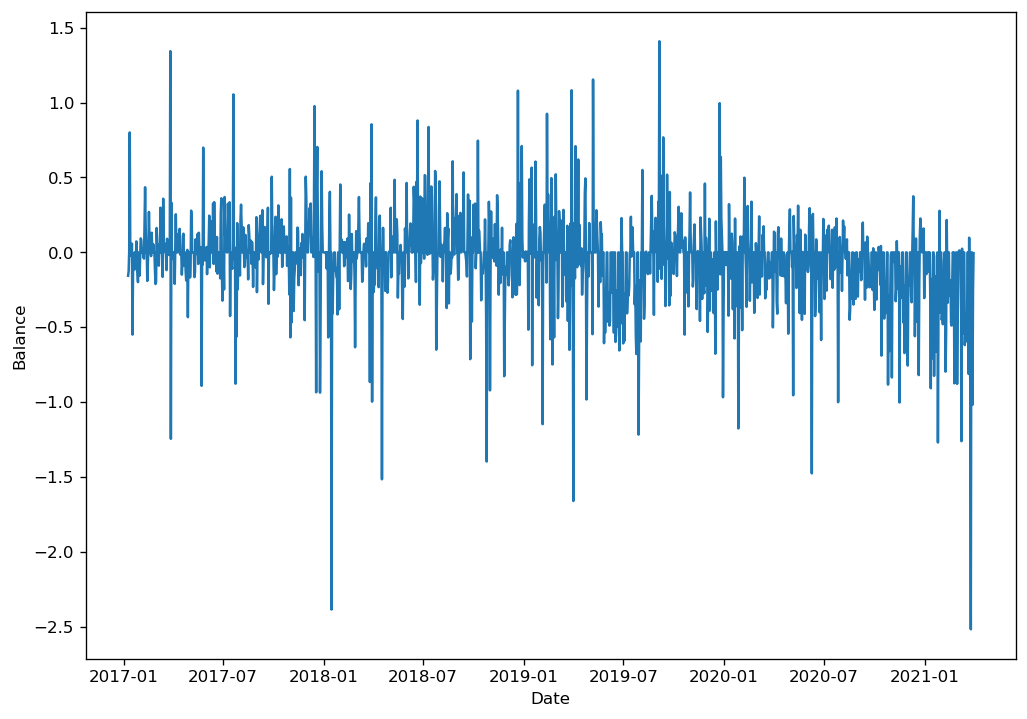

In [4]:
sns.lineplot(x = new_df.index, y = new_df.Balance)

# Тест Дики-Фуллера для проверки на стационарность

In [5]:
def adf_test(timeseries):
    print("Results of Dickey-Fuller Test:")
    dftest = adfuller(timeseries, autolag="AIC")
    dfoutput = pd.Series(
        dftest[0:4],
        index=[
            "Test Statistic",
            "p-value",
            "#Lags Used",
            "Number of Observations Used",
        ],
    )
    for key, value in dftest[4].items():
        dfoutput["Critical Value (%s)" % key] = value
    print(dfoutput)

In [6]:
adf_test(new_df.Balance)

Results of Dickey-Fuller Test:
Test Statistic                   -4.114101
p-value                           0.000918
#Lags Used                       20.000000
Number of Observations Used    1522.000000
Critical Value (1%)              -3.434654
Critical Value (5%)              -2.863441
Critical Value (10%)             -2.567782
dtype: float64


In [7]:
def check_stationarity(series):
    # Copied from https://machinelearningmastery.com/time-series-data-stationary-python/

    result = adfuller(series.values)

    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

    if (result[1] <= 0.05) & (result[4]['5%'] > result[0]):
        print("\u001b[32mStationary\u001b[0m")
    else:
        print("\x1b[31mNon-stationary\x1b[0m")

In [8]:
check_stationarity(new_df.Balance)

ADF Statistic: -4.114101
p-value: 0.000918
Critical Values:
	1%: -3.435
	5%: -2.863
	10%: -2.568
Stationary


# Избавляемся от выбросов

<Axes: xlabel='Date', ylabel='Balance'>

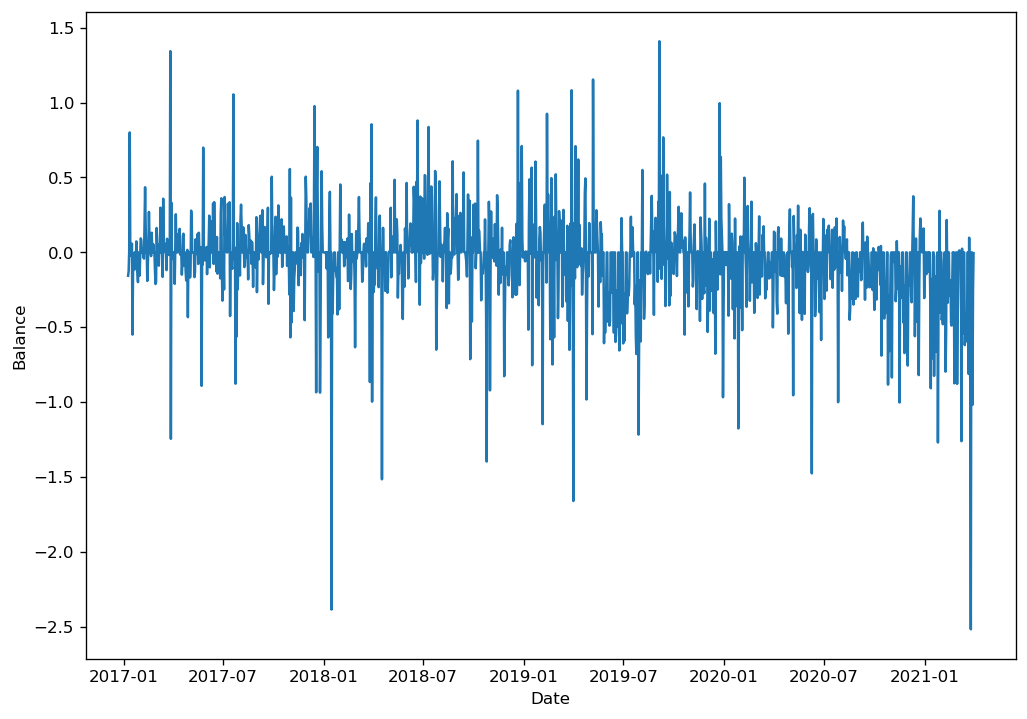

In [9]:
sns.lineplot(x = new_df.index, y = new_df.Balance)

In [10]:
def zscore(s, window, thresh=3, return_all=False):
    roll = s.rolling(window=window, min_periods=1, center=True)
    avg = roll.mean()
    std = roll.std(ddof=0)
    z = s.sub(avg).div(std)   
    m = z.between(-thresh, thresh)
    
    if return_all:
        return z, avg, std, m
    return s.where(m, avg)

Balance_balanced = zscore(new_df['Balance'], window=50)

<Axes: xlabel='Date', ylabel='Balance'>

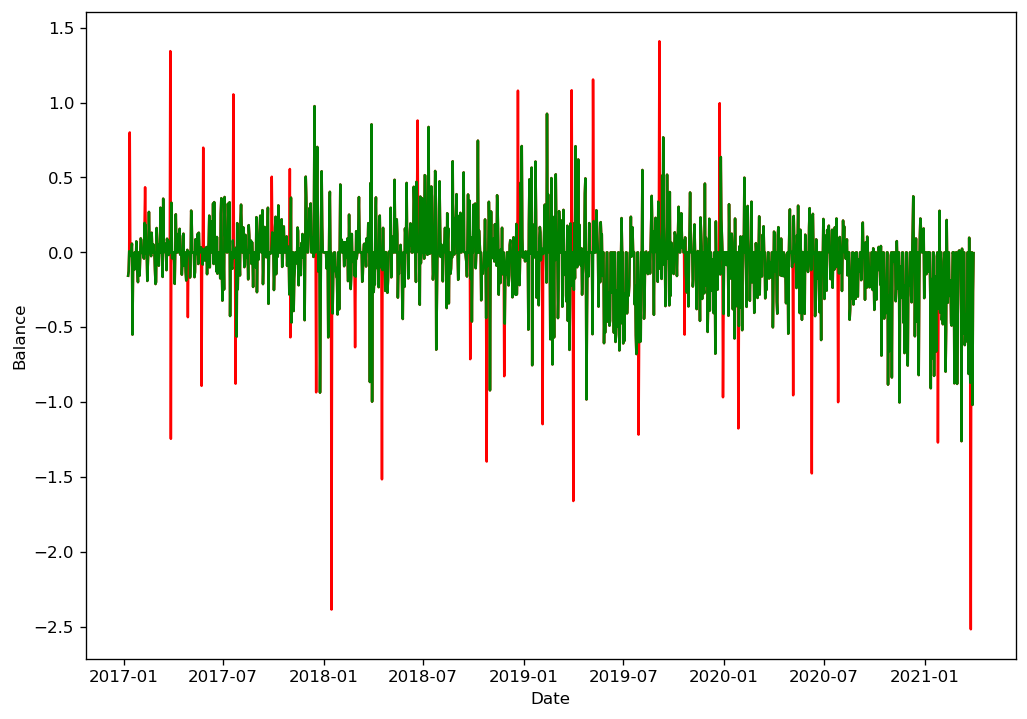

In [11]:
sns.lineplot(new_df.Balance, color='red')
sns.lineplot(Balance_balanced, color='green')

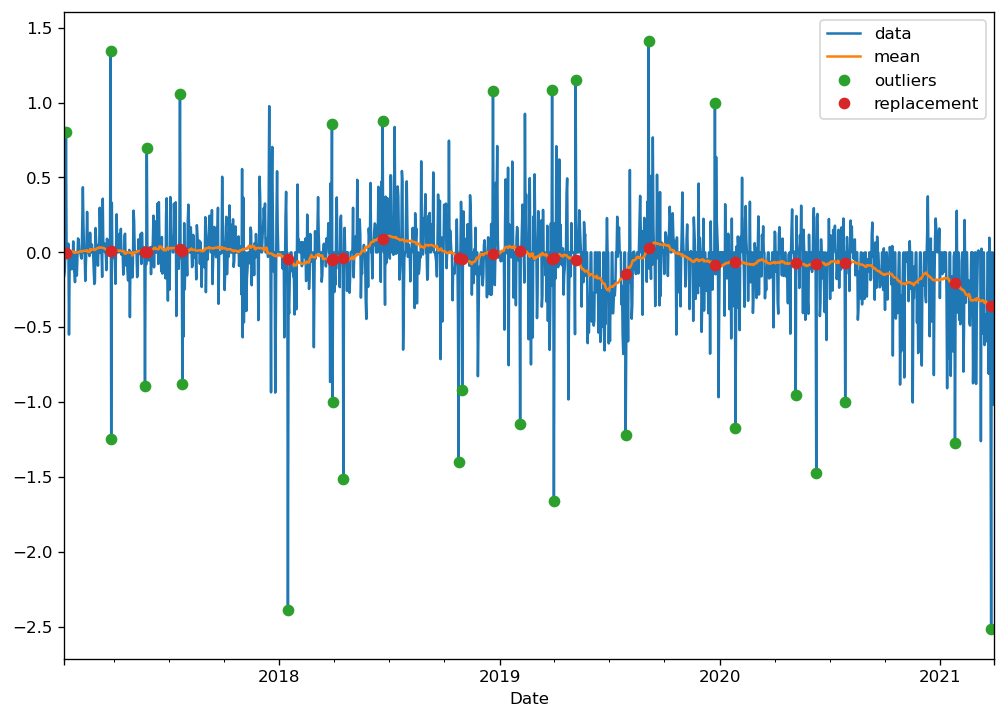

In [12]:
z, avg, std, m = zscore(new_df.Balance, window=70, return_all=True)

ax = plt.subplot()

new_df.Balance.plot(label='data')
avg.plot(label='mean')
new_df.loc[~m, 'Balance'].plot(label='outliers', marker='o', ls='')
avg[~m].plot(label='replacement', marker='o', ls='')
plt.legend()

Замену можно провести, все найс

In [13]:
new_df.Balance = Balance_balanced

<Axes: xlabel='Date', ylabel='Balance'>

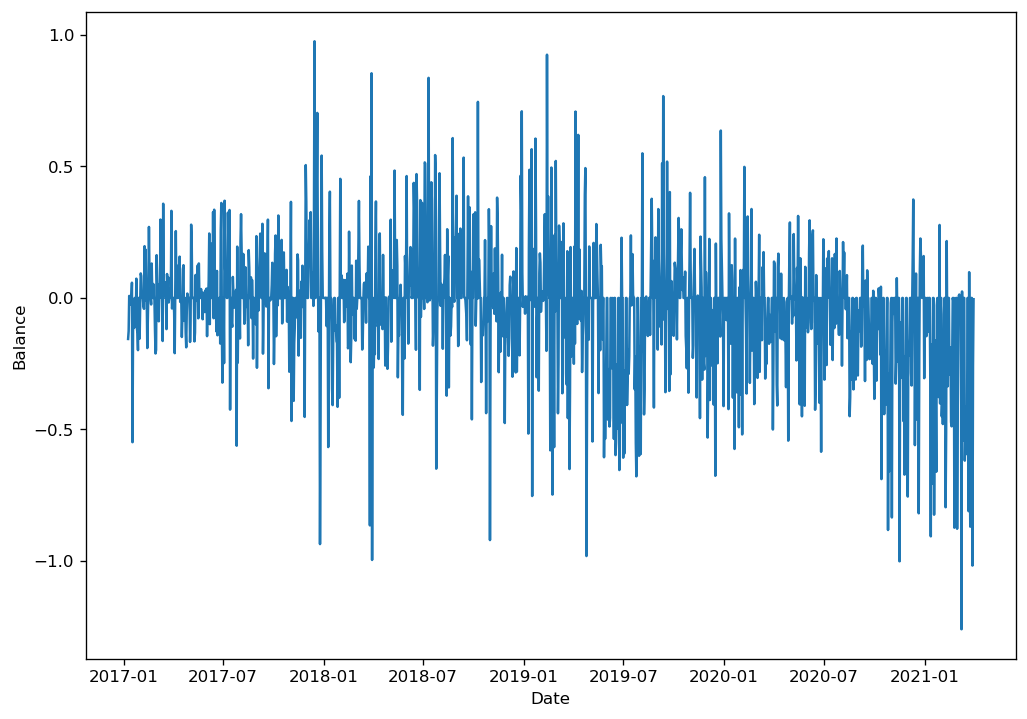

In [14]:
sns.lineplot(new_df.Balance)

https://stackoverflow.com/questions/75938497/outlier-detection-of-time-series-data

# Разложение на компоненты (попытка)

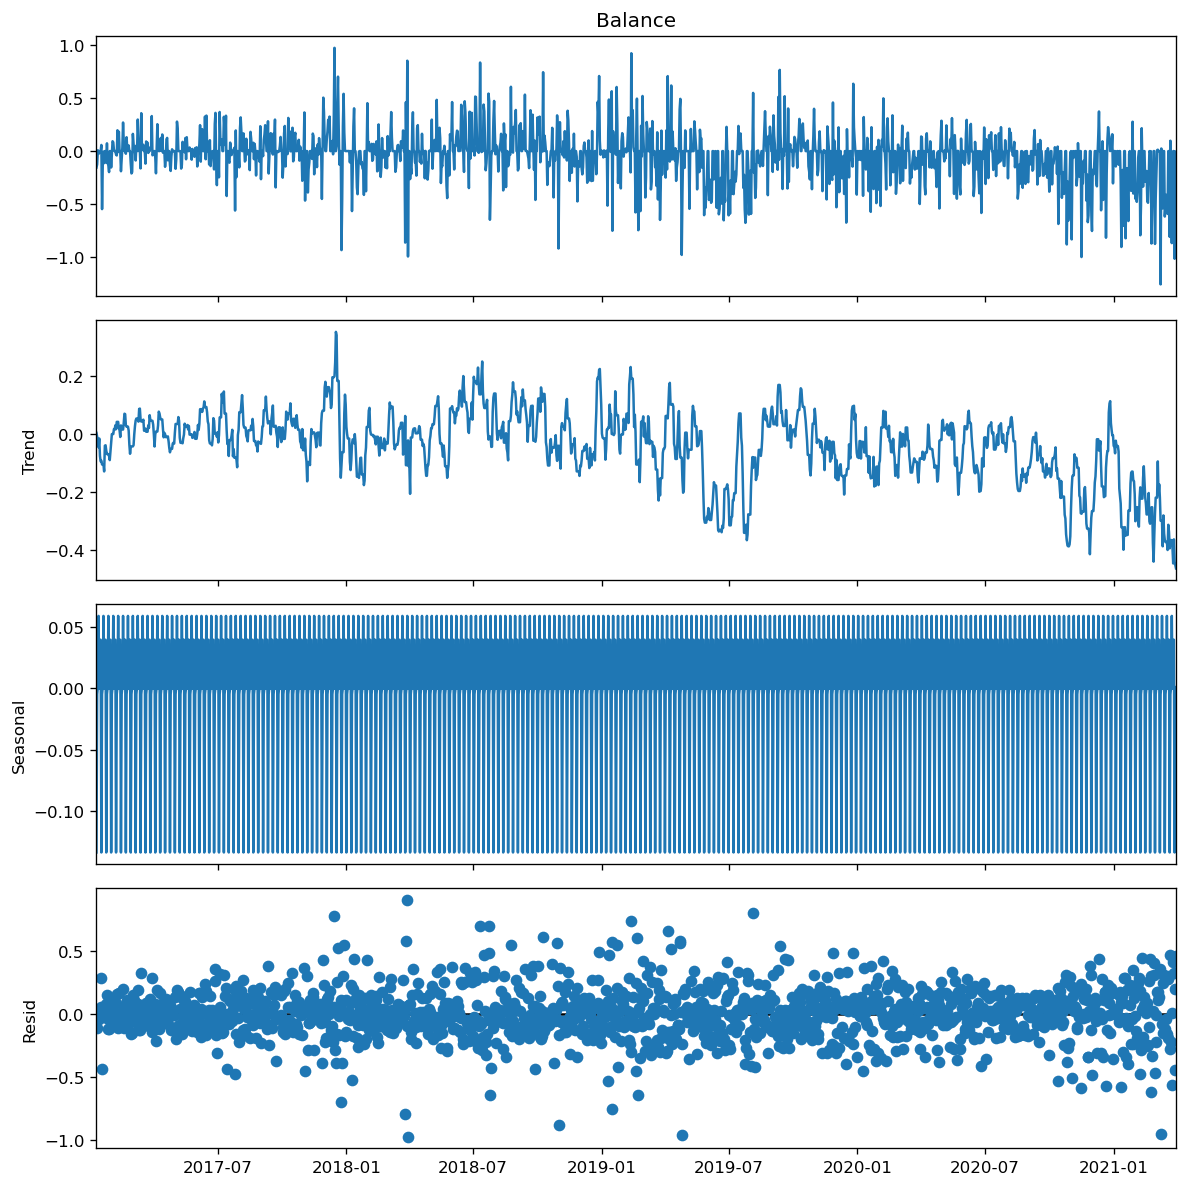

In [15]:
# Additive Decomposition
result_add = seasonal_decompose(new_df.Balance, model='additive', extrapolate_trend='freq')

# Plot
plt.rcParams.update({'figure.figsize': (10,10)})
result_add.plot()
seasonal = result_add.seasonal
plt.show()

In [16]:
BalanceD1 = (new_df.Balance - new_df.Balance.shift(7))[7:]

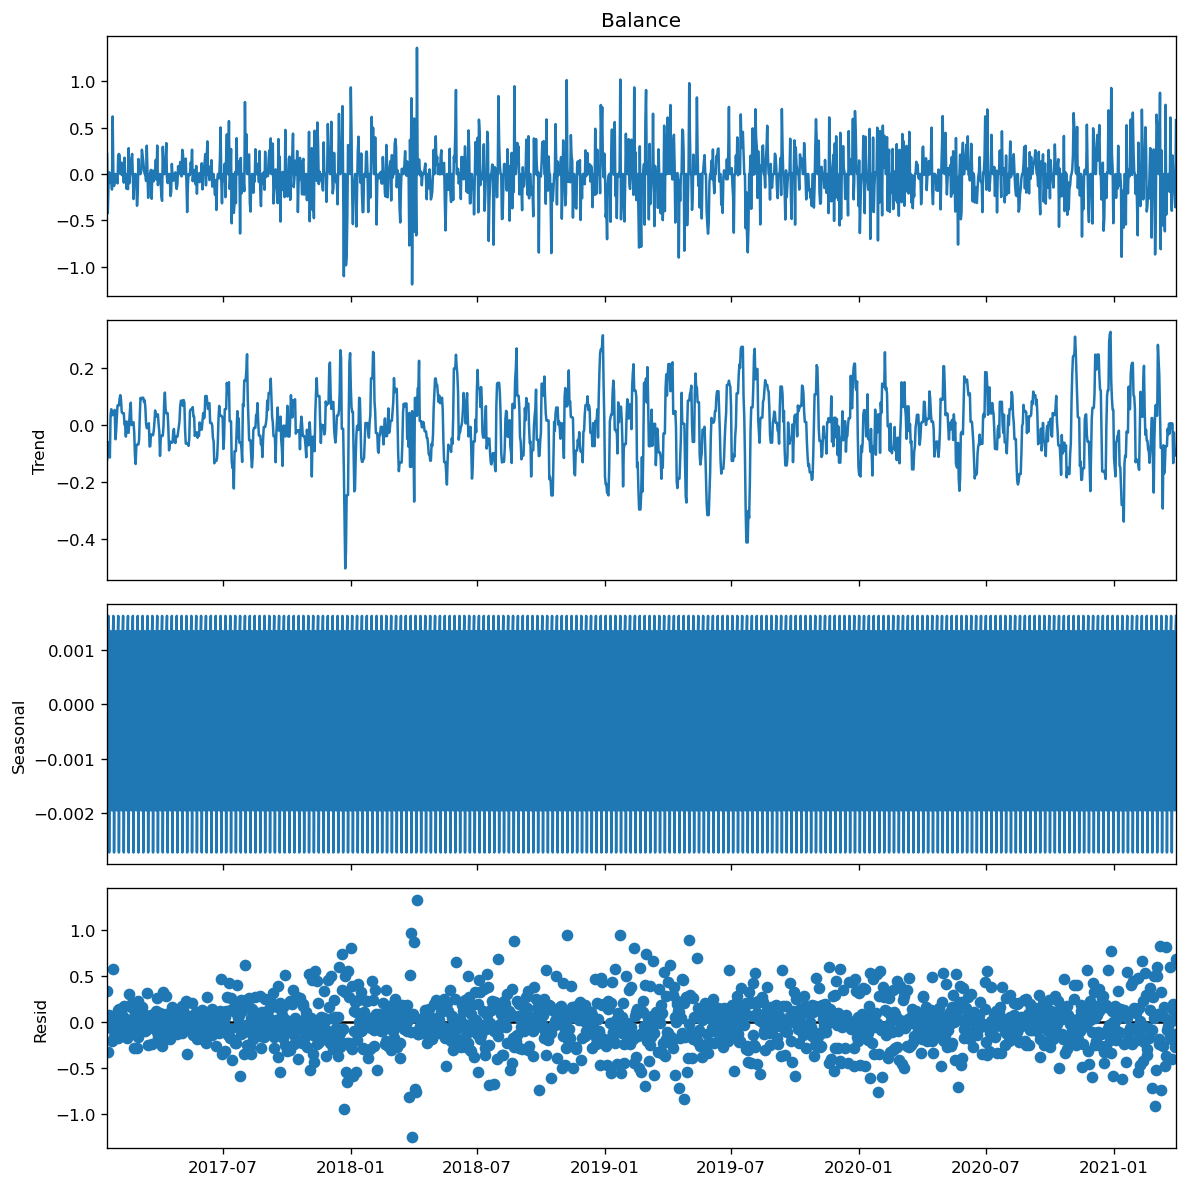

In [17]:
# Additive Decomposition
result_add2 = seasonal_decompose(BalanceD1, model='additive', extrapolate_trend='freq')

# Plot
plt.rcParams.update({'figure.figsize': (10,10)})
result_add2.plot()
seasonal2 = result_add2.seasonal
plt.show()

<Axes: xlabel='Date', ylabel='seasonal'>

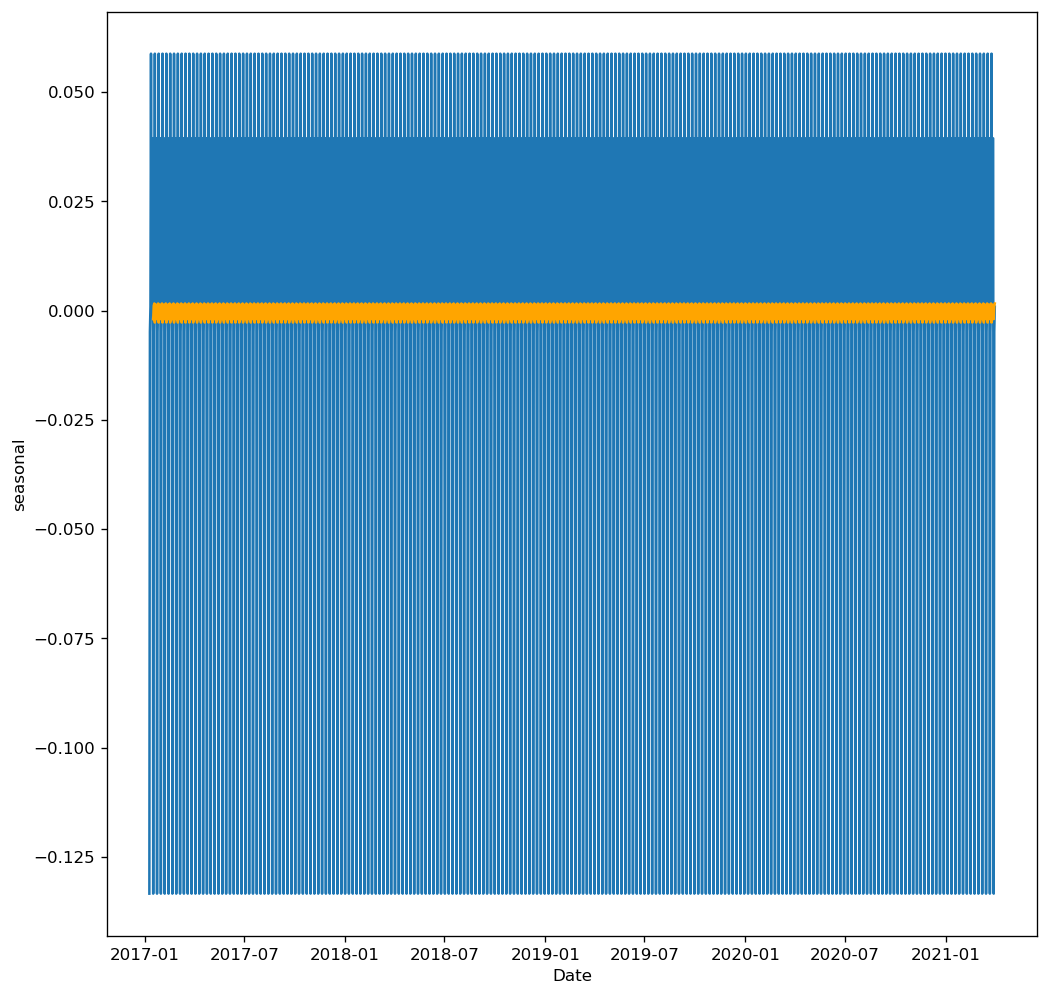

In [18]:
sns.lineplot(seasonal)
sns.lineplot(seasonal2, color='orange')

Сезонная компонента уменьшена

In [19]:
BalanceD2 = (BalanceD1 - BalanceD1.shift(7))[7:]

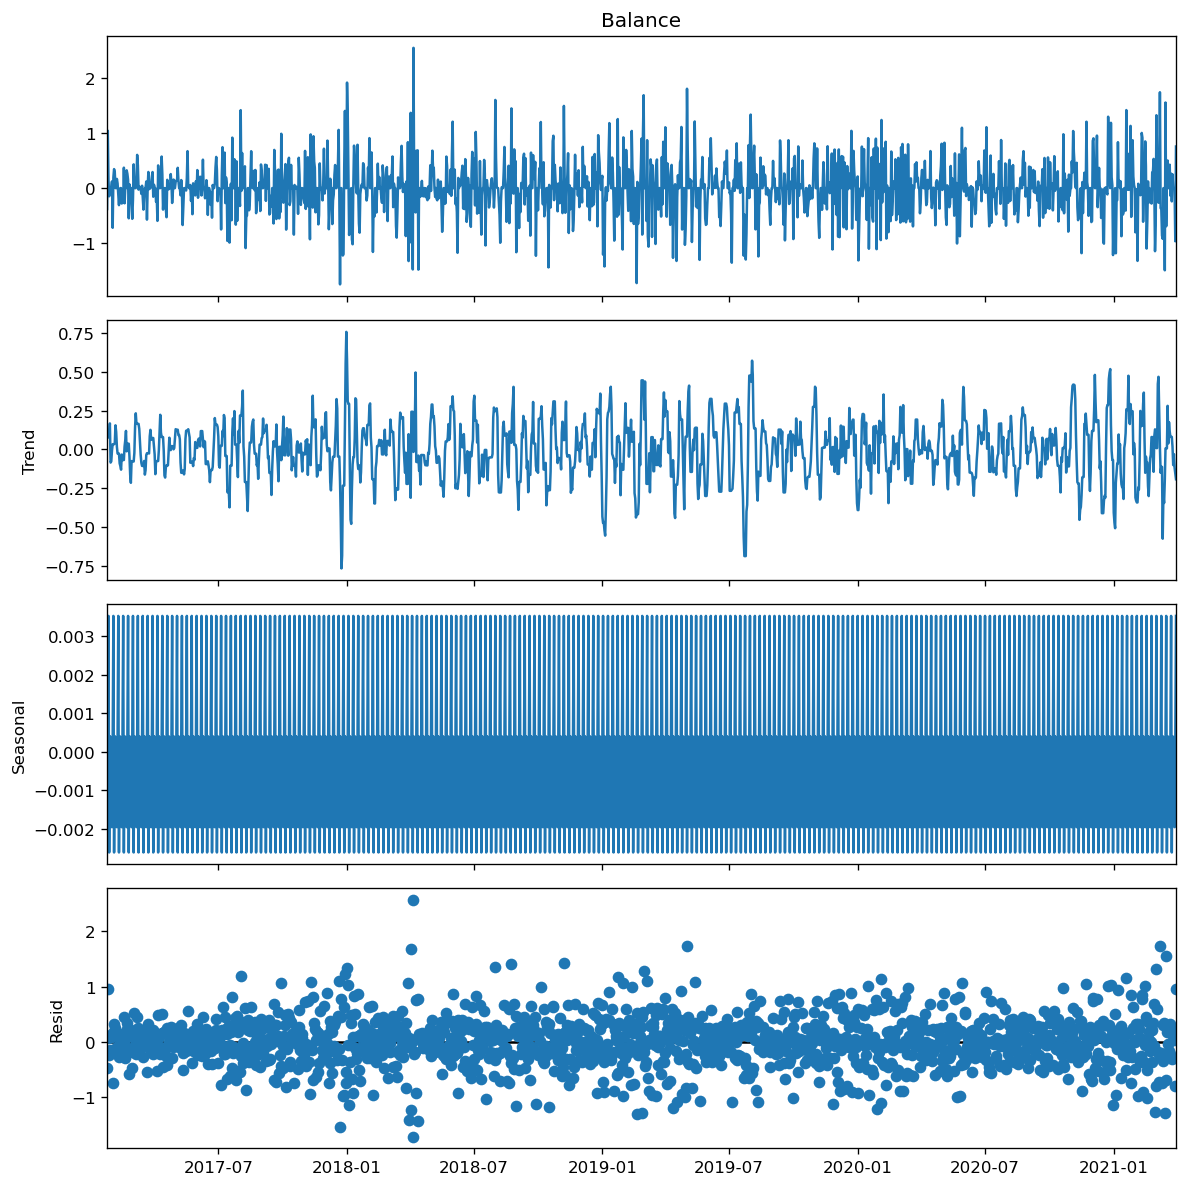

In [20]:
# Additive Decomposition
result_add3 = seasonal_decompose(BalanceD2, model='additive', extrapolate_trend='freq')

# Plot
plt.rcParams.update({'figure.figsize': (10,10)})
result_add3.plot()
seasonal3 = result_add2.seasonal
plt.show()

<Axes: xlabel='Date', ylabel='seasonal'>

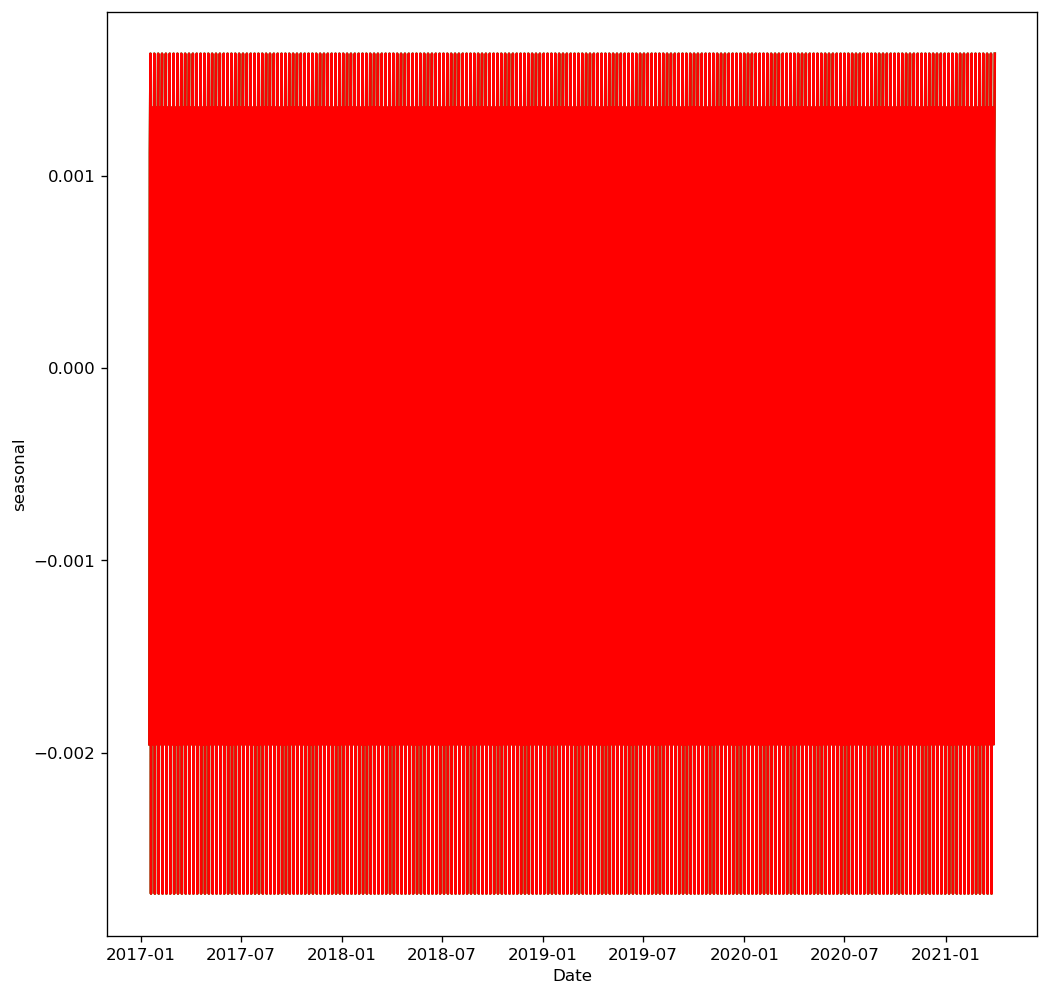

In [21]:
sns.lineplot(seasonal2, color='green')
sns.lineplot(seasonal3, color='red')

Толковых изменений нет

# Стабилизация Дисперсии (?)

# Изучение ACF/PACF

In [22]:
def tsplot(y, lags=None, figsize=(15, 15), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        #mpl.rcParams['font.family'] = 'Ubuntu Mono'
        layout = (3, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        qq_ax = plt.subplot2grid(layout, (2, 0))
        pp_ax = plt.subplot2grid(layout, (2, 1))
        
        y.plot(ax=ts_ax)
        ts_ax.set_title('Time Series Analysis Plots')
        
        sm.graphics.tsa.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        sm.graphics.tsa.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)
        sm.qqplot(y, line='s', ax=qq_ax)
        qq_ax.set_title('QQ Plot')        
        scs.probplot(y, sparams=(y.mean(), y.std()), plot=pp_ax)

        plt.tight_layout()
    return

np.random.seed(1)

# plot of discrete white noise


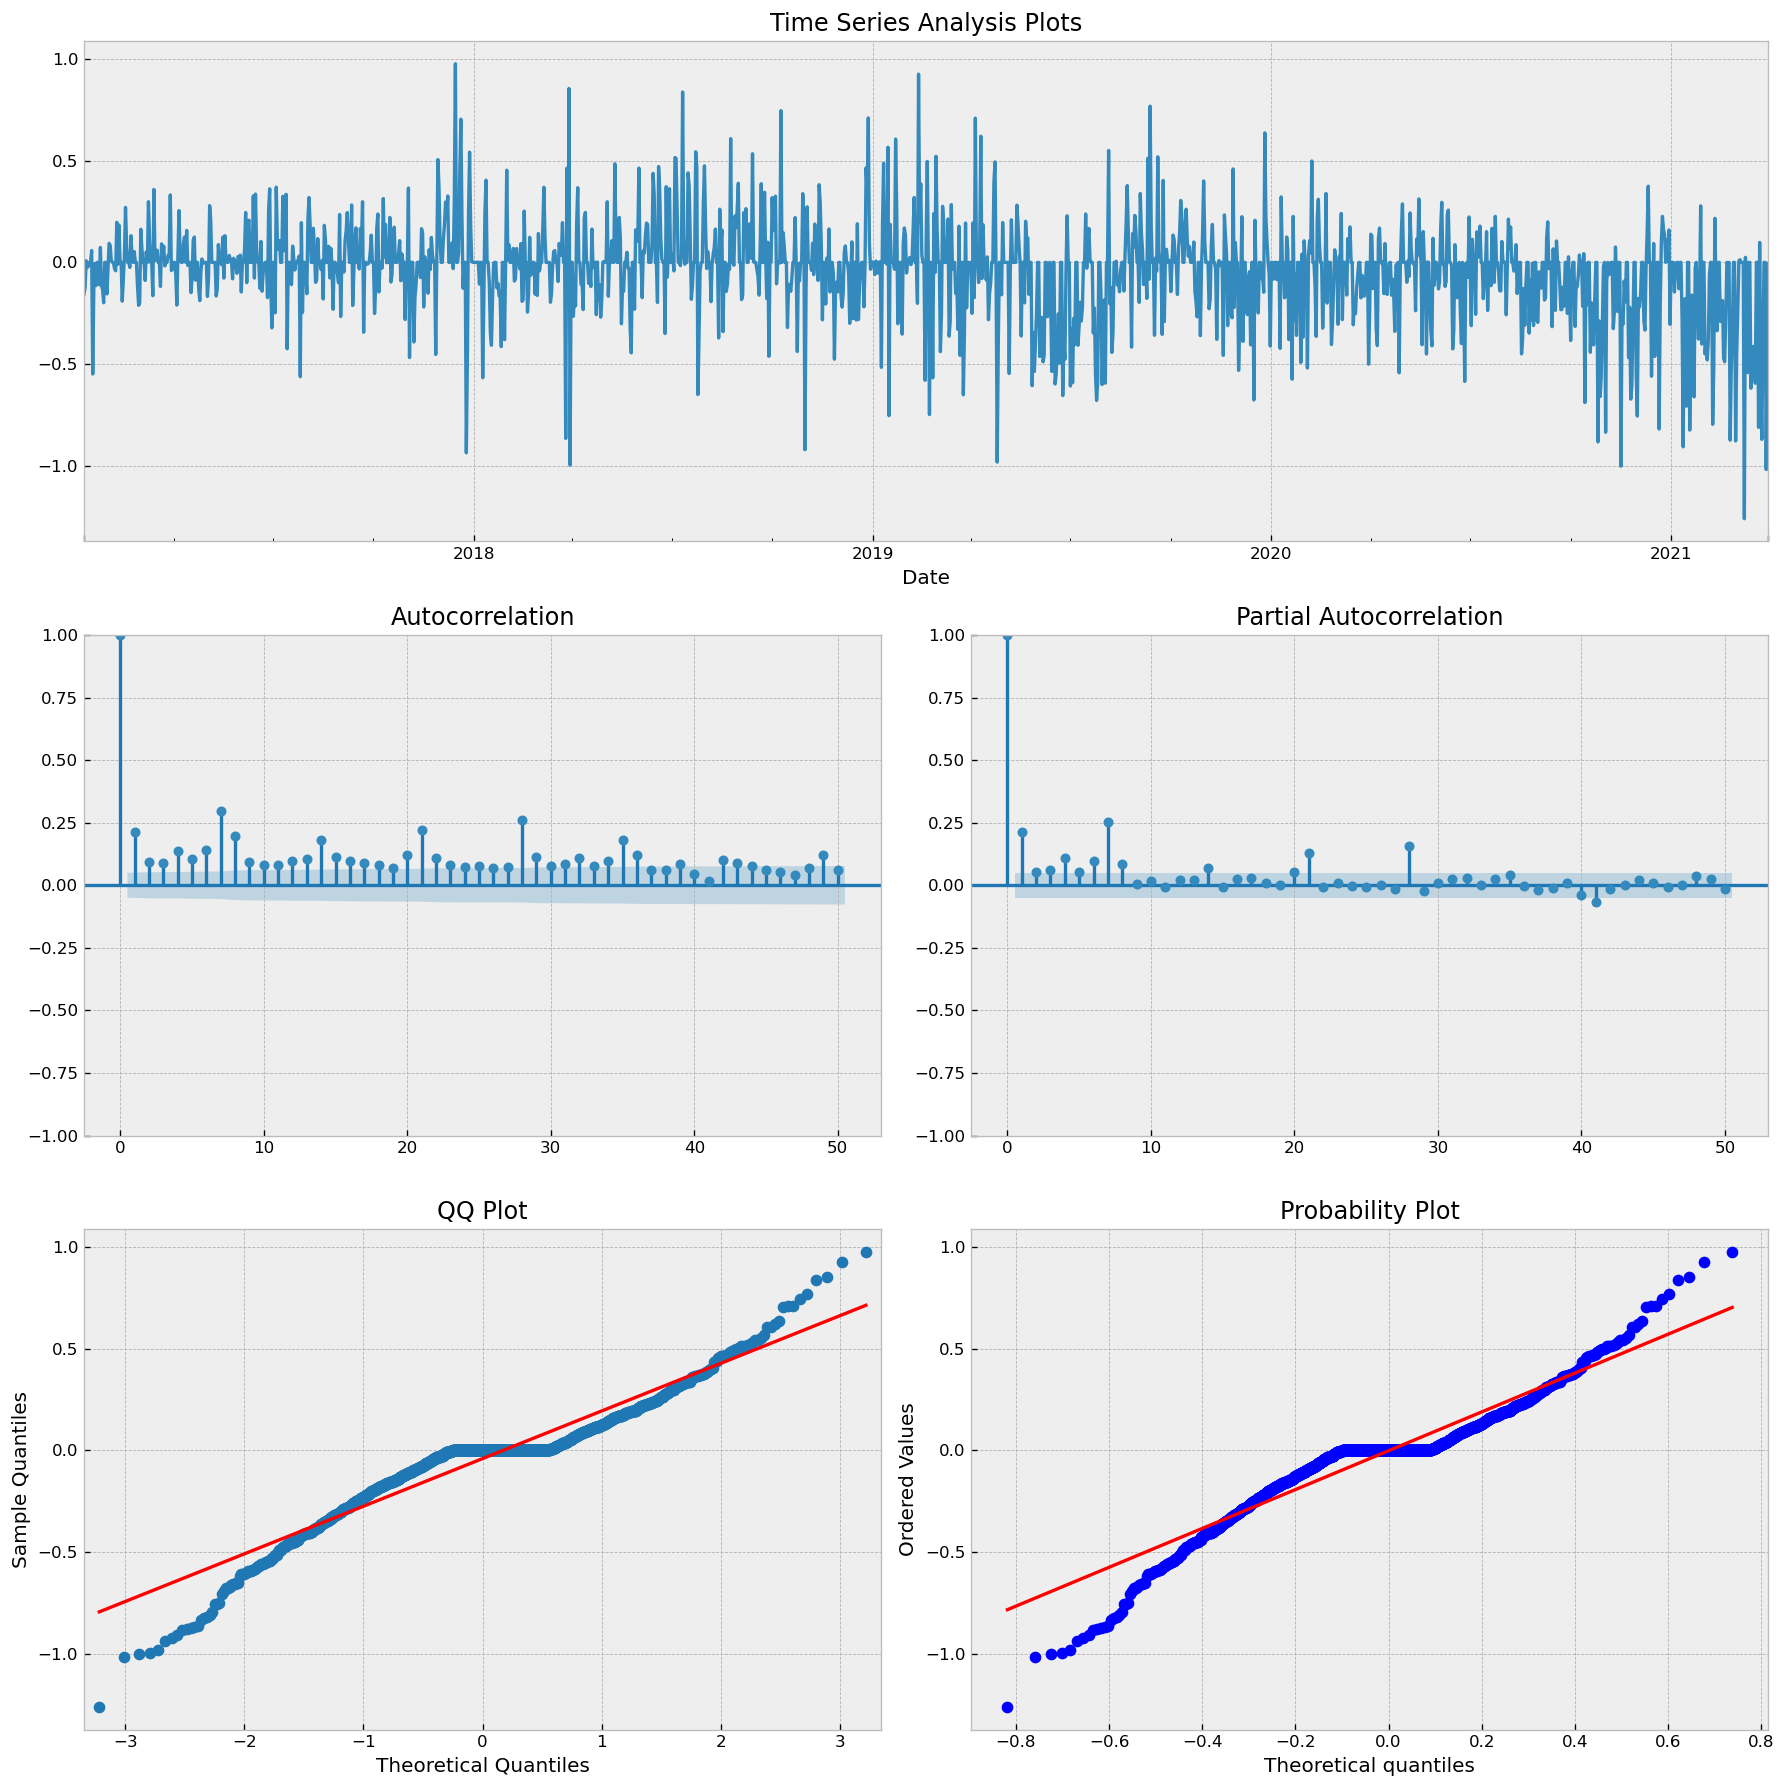

In [23]:
tsplot(new_df.Balance, lags=50)

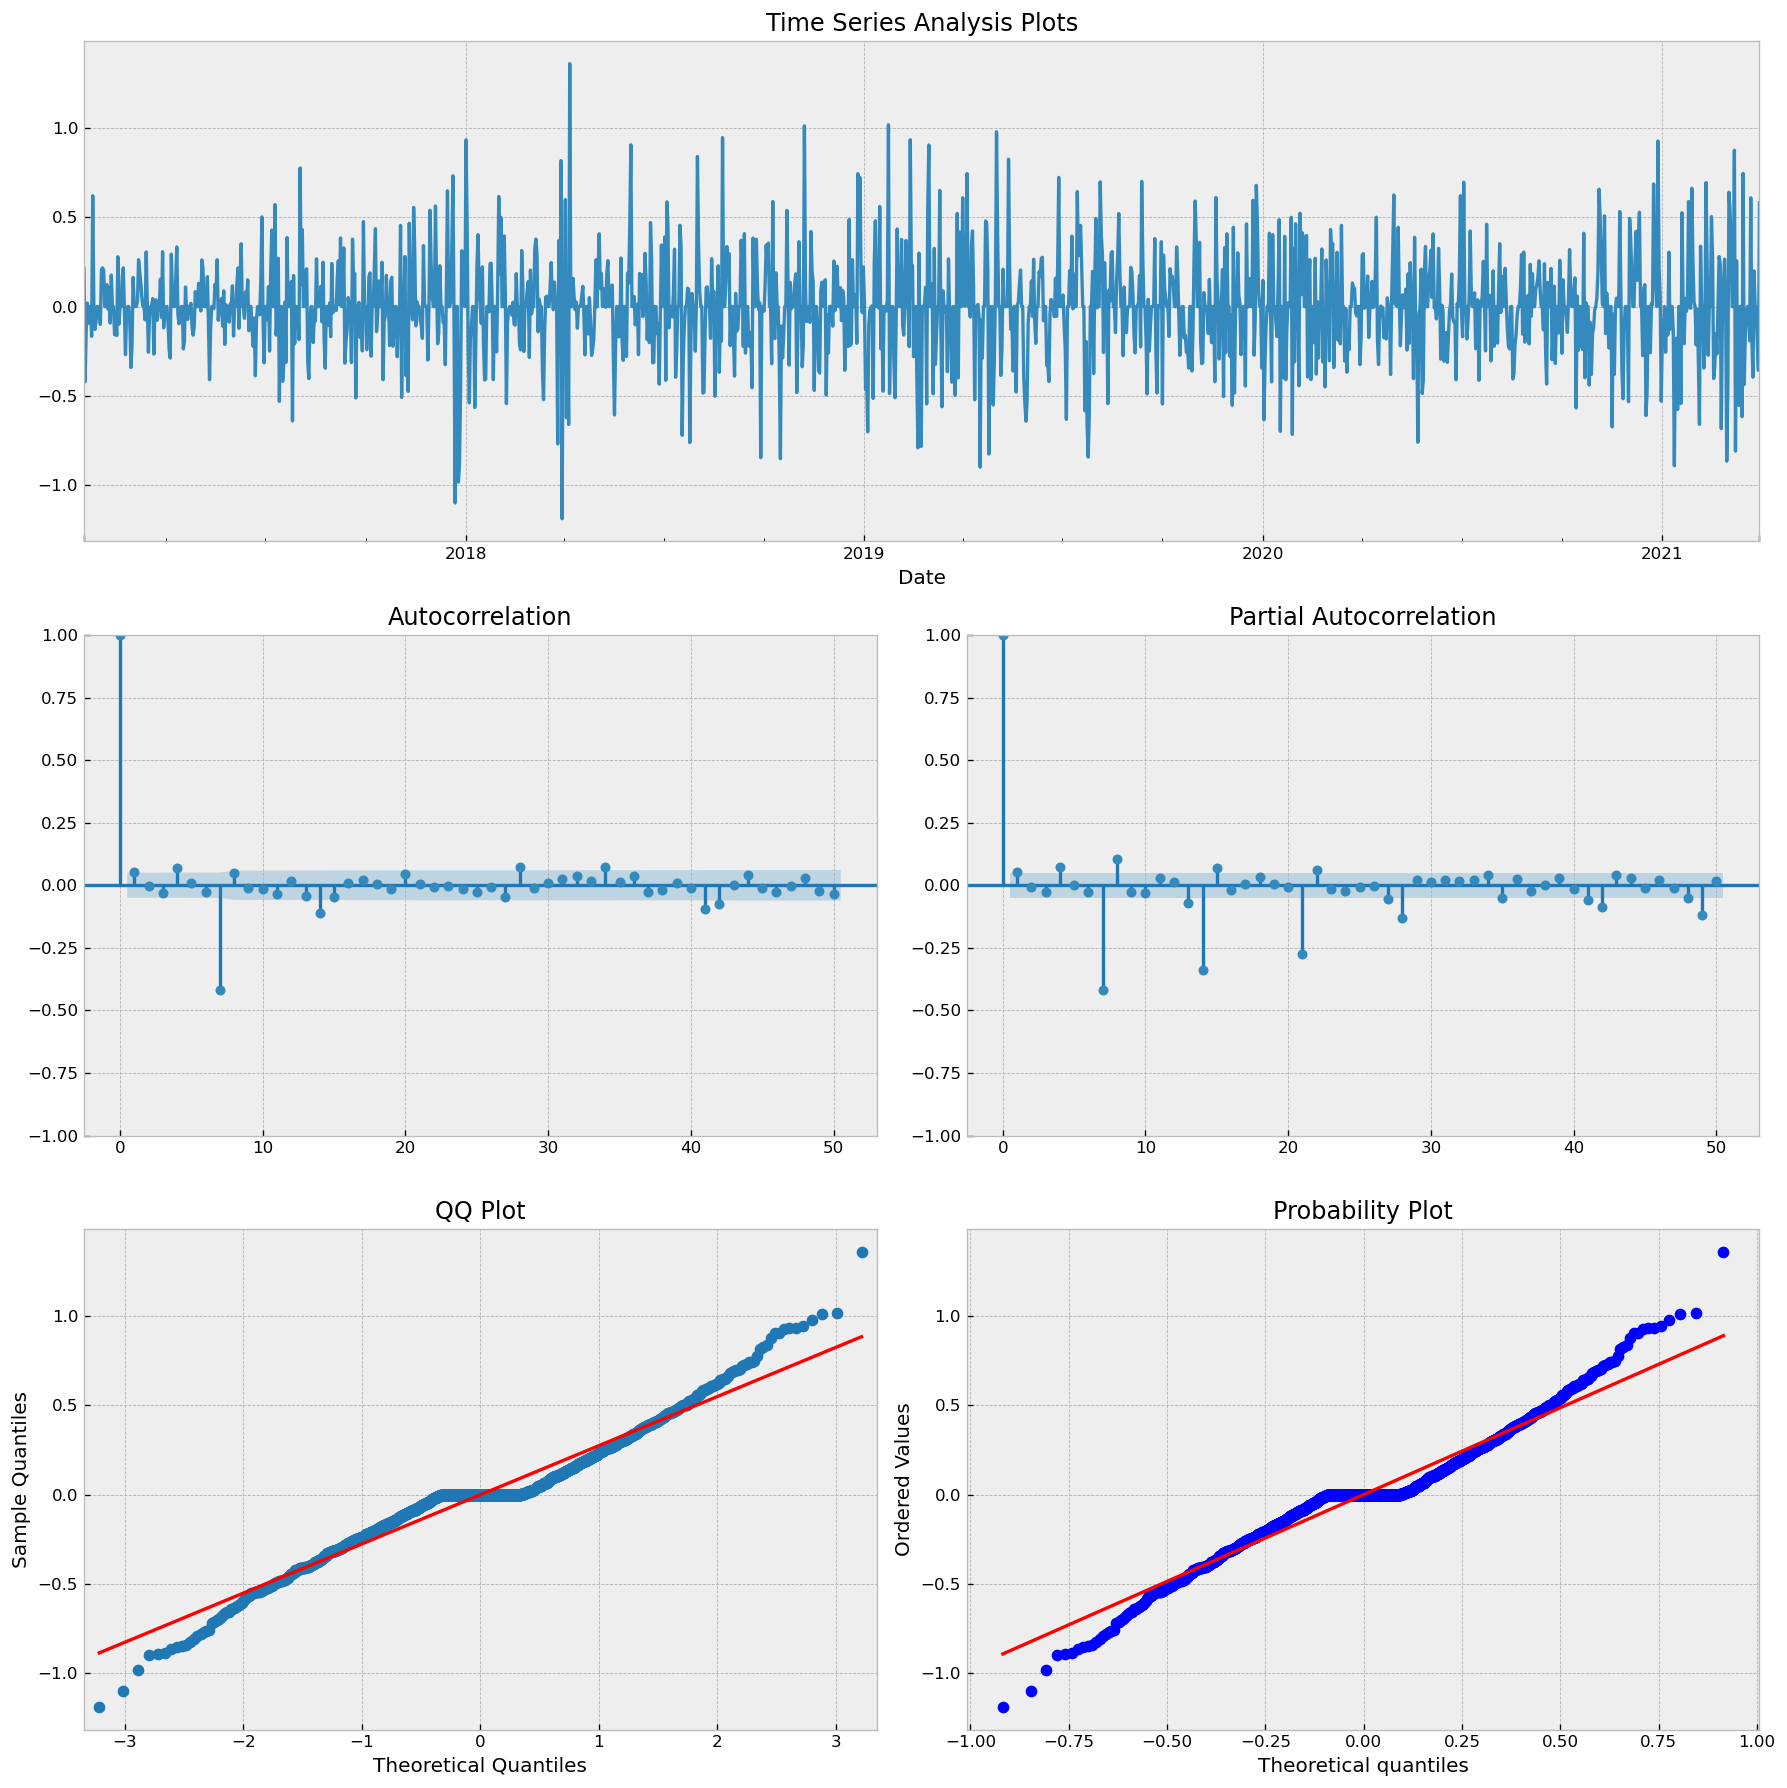

In [24]:
tsplot(BalanceD1, lags=50)

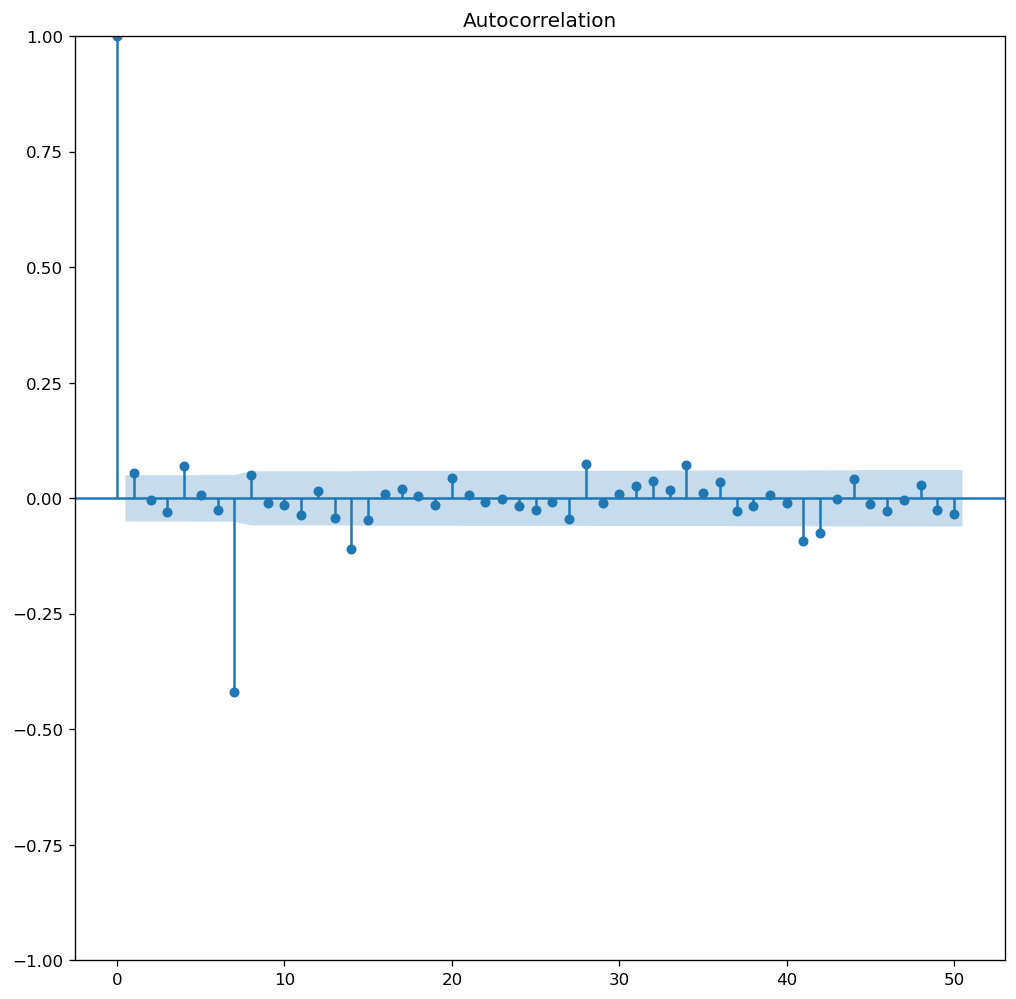

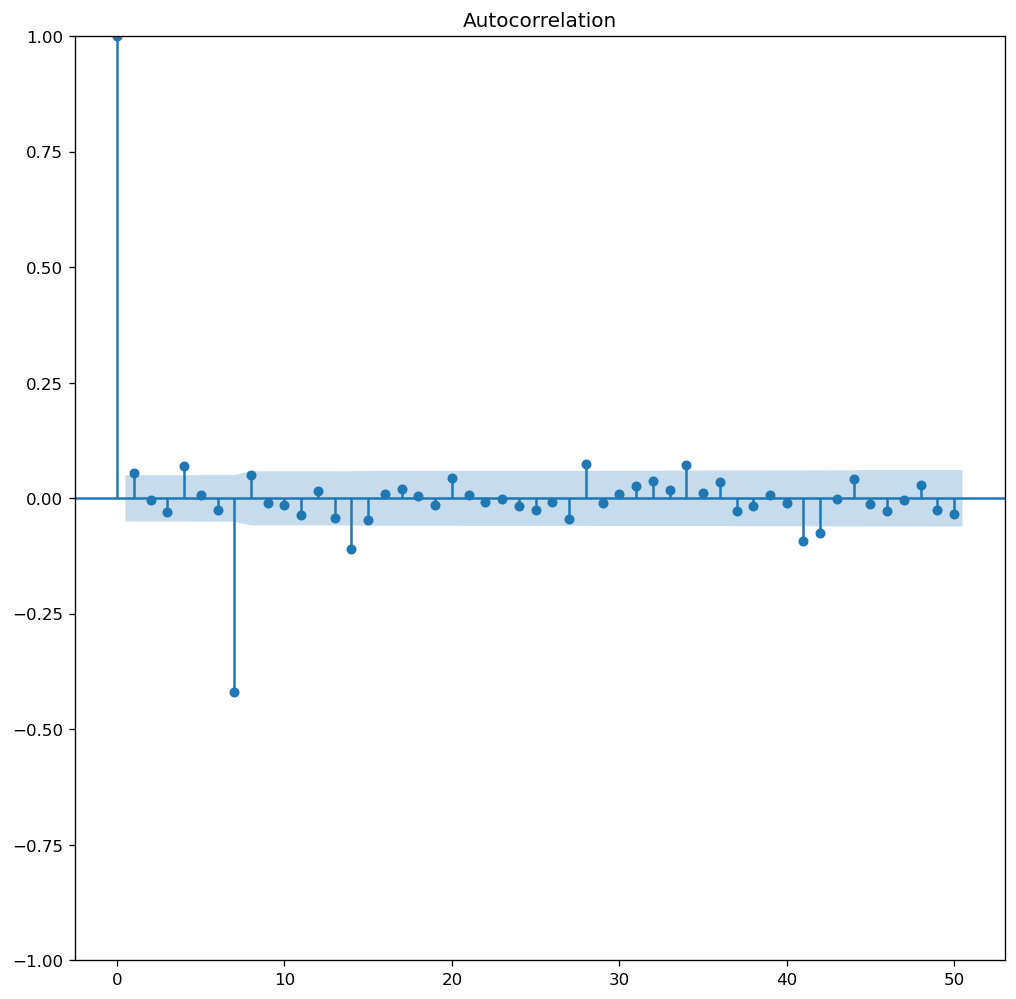

In [25]:
sm.graphics.tsa.plot_acf(BalanceD1, lags=50, alpha=0.05)

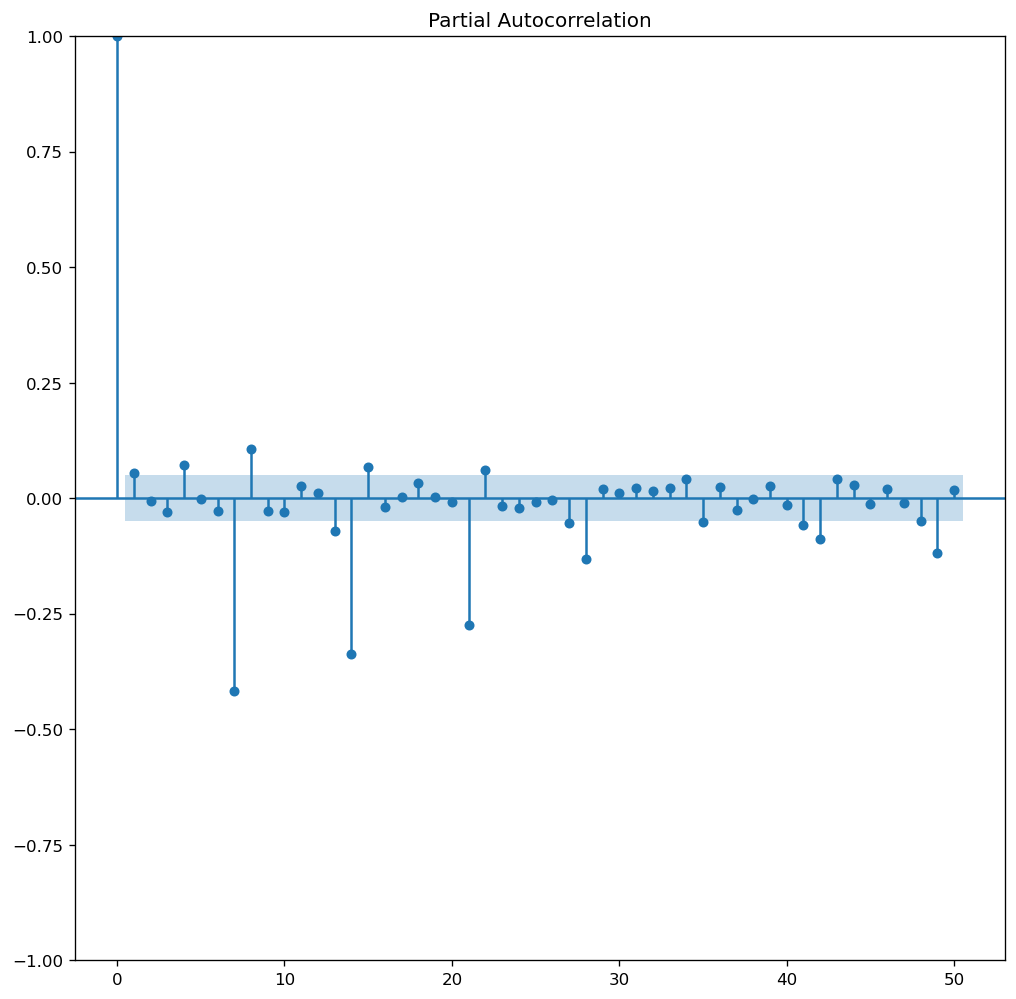

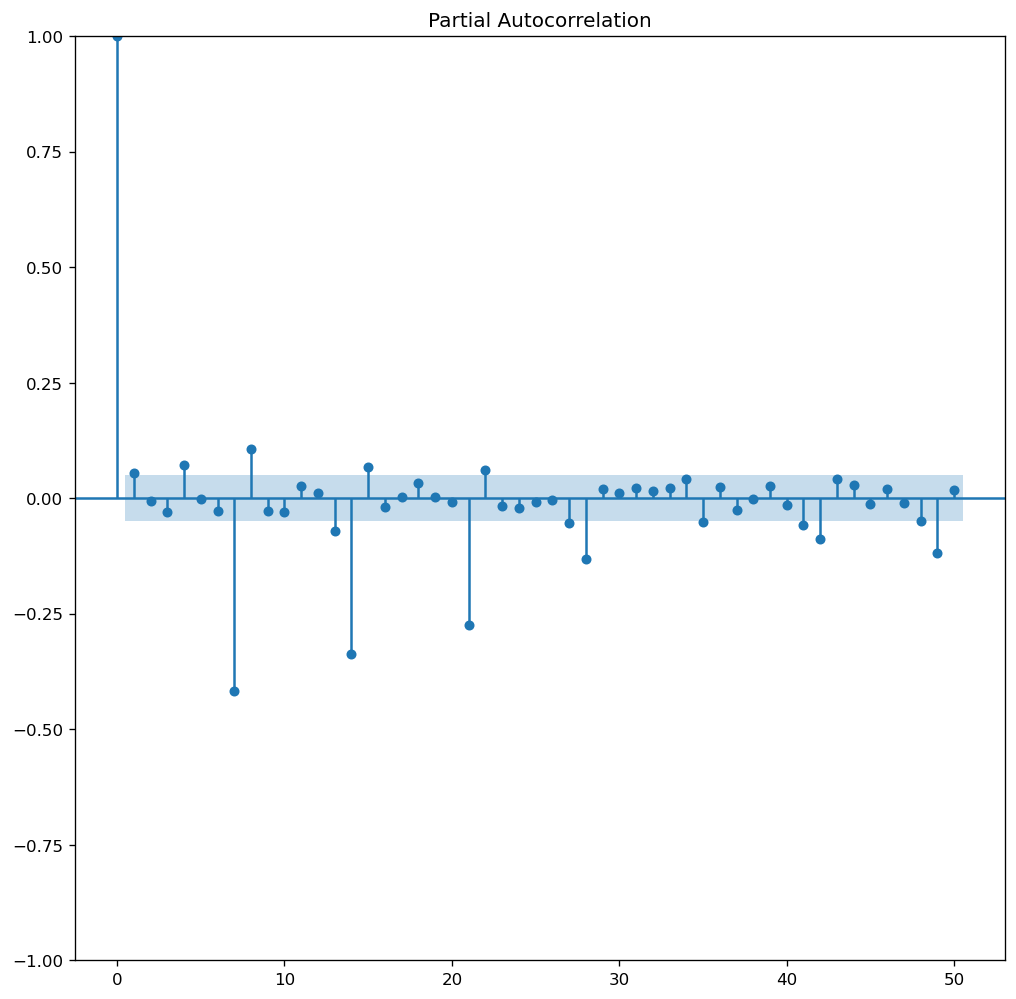

In [26]:
sm.graphics.tsa.plot_pacf(BalanceD1, lags=50, alpha=0.05)

Похоже на SARIMA(p=2, i=0, q=2, P=5, I=0, Q=1, S=7)

# Моделирование

In [27]:
start_date = new_df.index[0]
threshold_date = np.datetime64('2019-07-30')
end_date = new_df.index[-1]

In [28]:
import itertools
import math
from sklearn.metrics import r2_score, mean_absolute_error

# Define the range of values for p, d, q, P, D, Q, and m
p_values = range(0, 4)  # Autoregressive order
d_values = [0]          # Differencing order
q_values = range(0, 4)  # Moving average order
P_values = range(0, 5) # Seasonal autoregressive order
D_values = [1]  # Seasonal differencing order
Q_values = range(0, 3)  # Seasonal moving average order
m_values = [7]         # Seasonal period

# Create all possible combinations of SARIMA parameters
param_combinations = list(itertools.product(p_values, 
                                            d_values, 
                                            q_values, 
                                            P_values, 
                                            D_values, 
                                            Q_values, 
                                            m_values))
results_exog = []

# Initialize AIC with a large value
best_aic_SARIMAX = float("inf")  
best_params_SARIMAX = None
best_SARIMAX = None
mask_before = (new_df.index < threshold_date) & (new_df.index >= start_date)
mask_after = (new_df.index >= threshold_date) & (new_df.index <= end_date)

warnings.filterwarnings('ignore')


# Perform grid search
for params in tqdm(param_combinations):
    order = params[:3]
    seasonal_order = params[3:]
    
    try:
        model_chosen = ARIMA(endog=new_df[mask_before].Balance, 
                               order=order, 
                               seasonal_order=seasonal_order)
        model_chosen = model_chosen.fit()
        aic = model_chosen.aic
        
        # Ensure the convergence of the model
        if not math.isinf(model_chosen.zvalues.mean()):
            predict=model_chosen.predict(start=threshold_date, end=end_date, exog=None)
            err_max = (new_df.Balance[mask_after]-predict).abs().max()
            mae = mean_absolute_error(new_df.Balance[mask_after], predict)
            llf = model_chosen.llf
            r2 = r2_score(new_df.Balance[mask_after], predict)
            aic = model_chosen.aic
            if aic < best_aic_SARIMAX:
                best_aic_SARIMAX = aic
                best_params_SARIMAX = params
                best_SARIMAX = model_chosen
                best_err_max = err_max
                best_mae = mae
                best_llf = llf
                best_r2 = r2
                best_combination = params
                best_aic_SARIMAX = aic
            results_exog.append(list(params[:-1]) + [err_max, mae, llf, r2, aic])
        else:
            print(order, seasonal_order, 'not converged')
    except ValueError:
        print('wrong parameters:', params)
        continue

# Print the best parameters and AIC
print("Best Parameters:", best_params_SARIMAX)
print("Best AIC:", best_aic_SARIMAX)

  0%|          | 0/240 [00:00<?, ?it/s]

100%|██████████| 240/240 [10:36<00:00,  2.65s/it]

Best Parameters: (3, 0, 3, 0, 1, 2, 7)
Best AIC: -229.52734707689544


In [29]:
result_exog_table = pd.DataFrame(results_exog)
result_exog_table.columns = ['p', 'd', 'q', 'P', 'D', 'Q', 'err_max', 'MAE', 'LLF', 'R2', 'aic']
print("by LLF:")
display(result_exog_table.sort_values(by=['LLF'], ascending=False).head(1))
print("by err_max:")
display(result_exog_table.sort_values(by=['err_max'], ascending=True).head(1))
print("by MAE:")
display(result_exog_table.sort_values(by=['MAE'], ascending=True).head(1))
print("by aic:")
display(result_exog_table.sort_values(by=['aic'], ascending=True).head(1))
print("by R2:")
display(result_exog_table.sort_values(by=['R2'], ascending=False).head(1))

by LLF:


p  d  q  P  D  Q   err_max       MAE         LLF        R2         aic
238  3  0  3  4  1  1  1.275662  0.158165  126.514802 -0.041374 -229.029604

by err_max:


p  d  q  P  D  Q  err_max       MAE        LLF        R2         aic
12  0  0  0  4  1  0  1.05101  0.186349  65.841334 -0.269151 -121.682667

by MAE:


p  d  q  P  D  Q   err_max       MAE       LLF        R2       aic
115  1  0  3  3  1  1  1.217631  0.148332  116.5223  0.103093 -215.0446

by aic:


p  d  q  P  D  Q   err_max       MAE         LLF        R2         aic
227  3  0  3  0  1  2  1.243096  0.155513  123.763674  0.053889 -229.527347

by R2:


p  d  q  P  D  Q  err_max       MAE         LLF        R2         aic
215  3  0  2  1  1  2   1.1898  0.148608  118.746049  0.114726 -219.492097

In [30]:
best_SARIMAX.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                              Balance   No. Observations:                  932
Model:             ARIMA(3, 0, 3)x(0, 1, [1, 2], 7)   Log Likelihood                 123.764
Date:                              Fri, 05 Apr 2024   AIC                           -229.527
Time:                                      20:51:35   BIC                           -186.059
Sample:                                  01-09-2017   HQIC                          -212.944
                                       - 07-29-2019                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5552      0.051     10.839      0.000       0.455       0.656
ar.L2         -0.4772      0.058     -8.235      0.000      -0.591      -0.364
ar.L3          0.8684      0.042     20.538      0.000       0.786       0.951
ma.L1         -0.4433      0.051     -8.706      0.000      -0.543      -0.344
ma.L2          0.4442      0.048      9.197      0.000       0.350       0.539
ma.L3         -0.8497      0.043    -19.539      0.000      -0.935      -0.764
ma.S.L7       -0.8670      0.034    -25.704      0.000      -0.933      -0.801
ma.S.L14      -0.1092      0.033     -3.311      0.001      -0.174      -0.045
sigma2         0.0438      0.001     35.142      0.000       0.041       0.046
===================================================================================
Ljung-Box (L1) (Q):                   2.07   Jarque-Bera (JB):               575.87
Prob(Q):                              0.15   Prob(JB):                         0.00
Heteroskedasticity (H):               3.22   Skew:                            -0.23
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.84
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [31]:
from pmdarima.datasets import load_lynx
from pmdarima.arima.utils import nsdiffs

# estimate number of seasonal differences using a Canova-Hansen test
D = nsdiffs(new_df.Balance,
            m=10,  # commonly requires knowledge of dataset
            max_D=12,
            test='ch')  # -> 0
D

0

In [32]:
import pmdarima as pm
best_auto = pm.AutoARIMA(
                        # test='adf',
                        # start_p=0, max_p=4,
                        # d=0,
                        # start_q=0, max_q=4,
                        # start_P=0, max_P=5,
                        start_D=0, max_D=2,
                        # start_Q=0, max_Q=5,
                        m=7,
                        seasonal=True,
                        stationary=True,
                        trace=True,
                        suppress_warnings=True,
                        error_action='ignore',
                        stepwise=True
                      ).fit(y=new_df.Balance[mask_before])


Performing stepwise search to minimize aic


 ARIMA(2,0,2)(1,0,1)[7] intercept   : AIC=-227.398, Time=1.68 sec
 ARIMA(0,0,0)(0,0,0)[7] intercept   : AIC=-157.255, Time=0.15 sec
 ARIMA(1,0,0)(1,0,0)[7] intercept   : AIC=-218.466, Time=0.18 sec
 ARIMA(0,0,1)(0,0,1)[7] intercept   : AIC=-214.202, Time=0.22 sec
 ARIMA(0,0,0)(0,0,0)[7]             : AIC=-158.935, Time=0.04 sec
 ARIMA(2,0,2)(0,0,1)[7] intercept   : AIC=-227.659, Time=1.47 sec
 ARIMA(2,0,2)(0,0,0)[7] intercept   : AIC=-208.725, Time=0.99 sec
 ARIMA(2,0,2)(0,0,2)[7] intercept   : AIC=-215.185, Time=2.24 sec
 ARIMA(2,0,2)(1,0,0)[7] intercept   : AIC=-217.471, Time=1.29 sec
 ARIMA(2,0,2)(1,0,2)[7] intercept   : AIC=-228.698, Time=2.45 sec
 ARIMA(2,0,2)(2,0,2)[7] intercept   : AIC=-229.705, Time=2.78 sec
 ARIMA(2,0,2)(2,0,1)[7] intercept   : AIC=-229.942, Time=1.99 sec
 ARIMA(2,0,2)(2,0,0)[7] intercept   : AIC=-215.782, Time=2.26 sec
 ARIMA(1,0,2)(2,0,1)[7] intercept   : AIC=-233.886, Time=2.05 sec
 ARIMA(1,0,2)(1,0,1)[7] intercept   : AIC=-229.380, Time=1.35 sec
 ARIMA(1,0

In [33]:
best_auto.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                       SARIMAX Results                                        
==============================================================================================
Dep. Variable:                                      y   No. Observations:                  932
Model:             SARIMAX(1, 0, 0)x(1, 0, [1, 2], 7)   Log Likelihood                 124.597
Date:                                Fri, 05 Apr 2024   AIC                           -239.193
Time:                                        20:52:37   BIC                           -215.007
Sample:                                    01-09-2017   HQIC                          -229.969
                                         - 07-29-2019                                         
Covariance Type:                                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1581      0.025      6.202      0.000       0.108       0.208
ar.S.L7        0.9651      0.022     43.853      0.000       0.922       1.008
ma.S.L7       -0.8014      0.034    -23.478      0.000      -0.868      -0.734
ma.S.L14      -0.1003      0.030     -3.341      0.001      -0.159      -0.041
sigma2         0.0447      0.001     36.384      0.000       0.042       0.047
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               668.96
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               3.21   Skew:                            -0.21
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.13
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Максимальная и средняя ошибки для выбранной авто:

In [34]:
predict_auto=best_auto.predict_in_sample(start=threshold_date, end=end_date)
err_auto = (new_df.Balance[mask_after]-predict_auto).abs()
print(err_auto.max(), err_auto.mean())

1.2558829861373564 0.16189759349497895


Максимальная и средняя ошибки для выбранной перебором:

In [35]:
predict_chosen = best_SARIMAX.predict(start=threshold_date, end=end_date)
err_chosen = (new_df.Balance[mask_after]-predict_chosen).abs()
print(err_chosen.max(), err_chosen.mean())

1.2430956413970613 0.15551274687633912


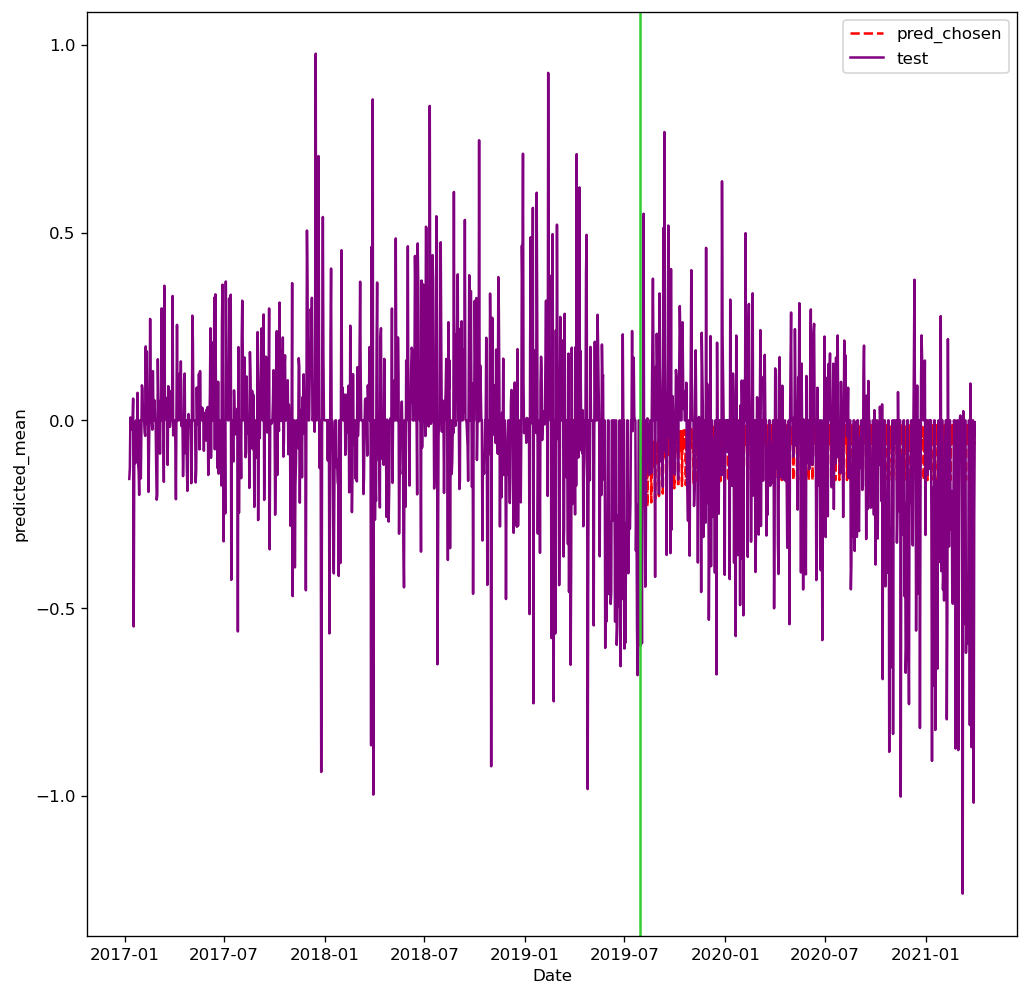

In [36]:
sns.lineplot(x=new_df.index[mask_after], y=predict_chosen, label='pred_chosen', linestyle='dashed', color='red')
sns.lineplot(x=new_df.index, y=new_df.Balance, label='test', color = 'purple')
plt.axvline(x=threshold_date, color='limegreen')

<Axes: xlabel='Date', ylabel='predicted_mean'>

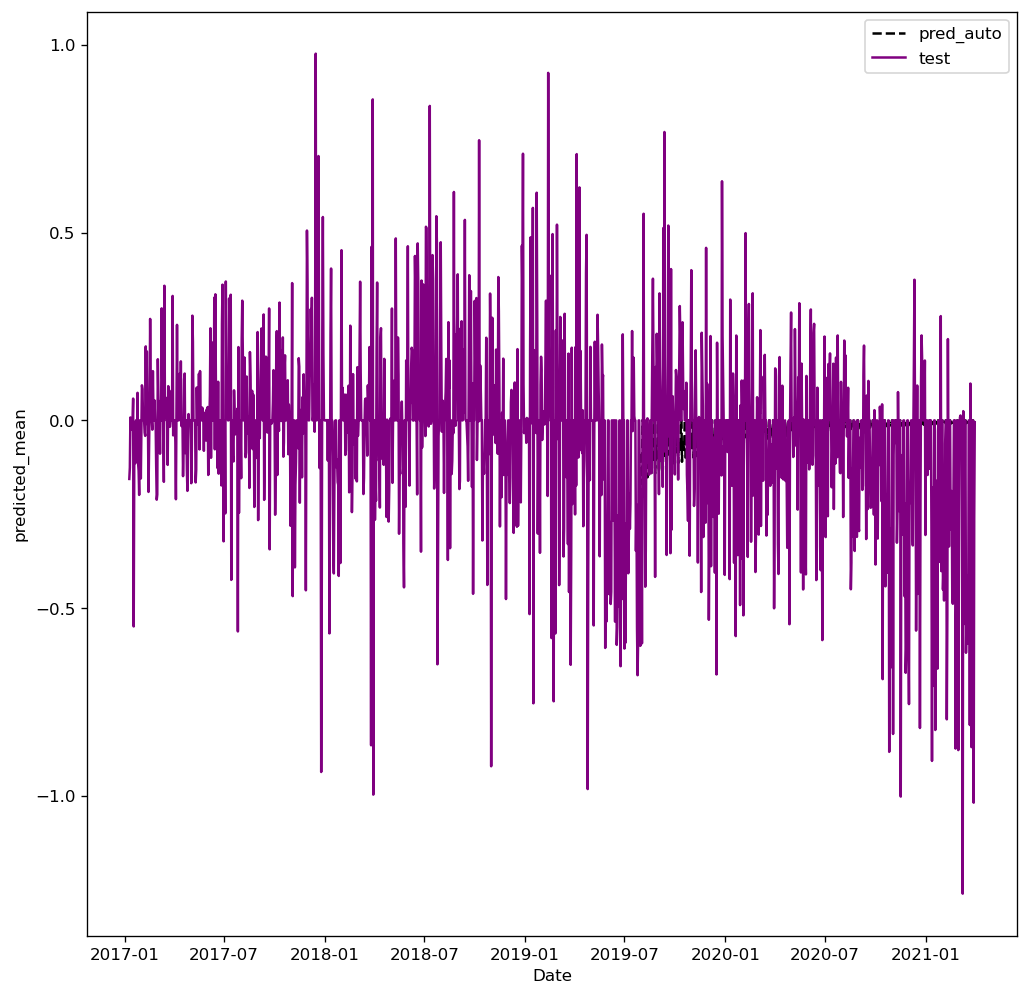

In [37]:
sns.lineplot(x=new_df.index[mask_after], y=predict_auto, label='pred_auto', linestyle='dashed', color='black')
sns.lineplot(x=new_df.index, y=new_df.Balance, label='test', color = 'purple')

<Axes: xlabel='Date'>

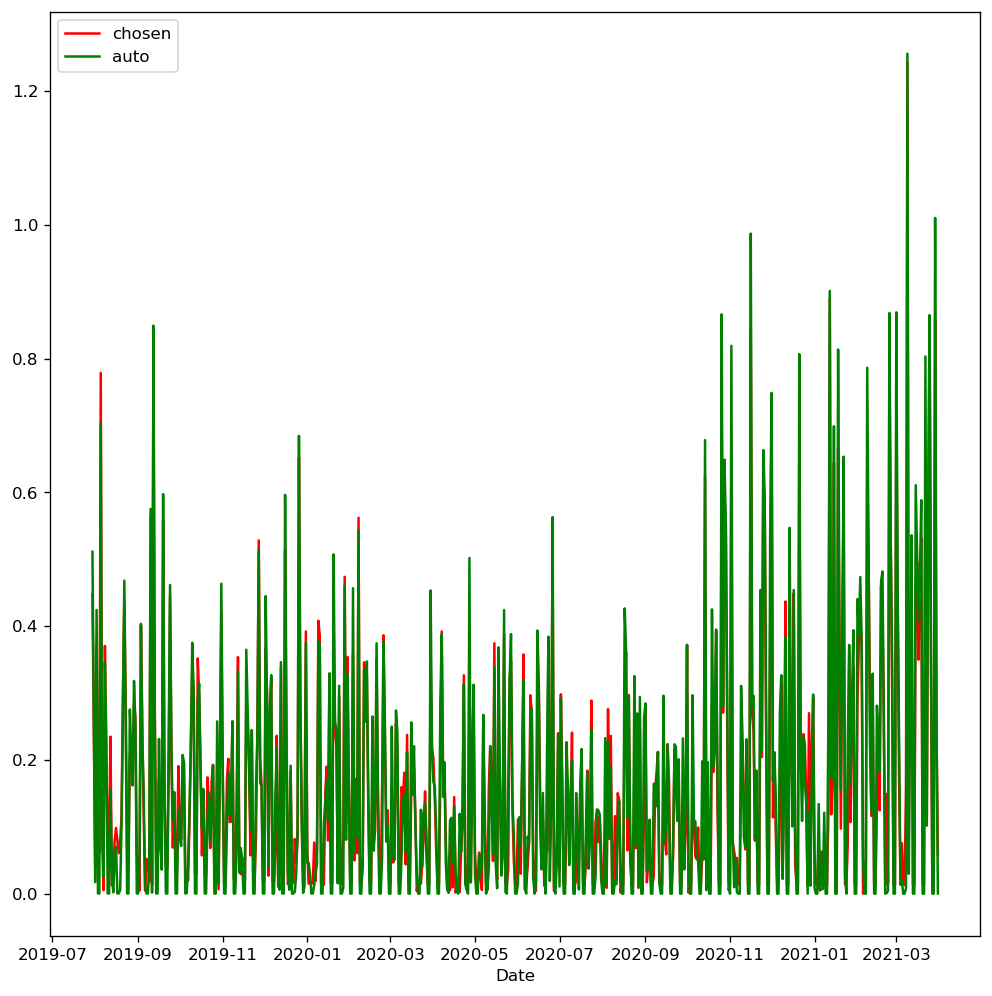

In [38]:
sns.lineplot(x=new_df.index[mask_after], y=(new_df.Balance[mask_after]-predict_chosen).abs(), label='chosen', color = 'red')
sns.lineplot(x=new_df.index[mask_after], y=(new_df.Balance[mask_after]-predict_auto).abs(), label='auto', color = 'green')

# sns.lineplot(x=df.index[mask][21:], y=df.Balance[mask][21:], label='test', color = 'purple')

Попробуем выбрать из тех, что с минимальной MAE

In [39]:
display(result_exog_table.sort_values(by=['MAE'], ascending=False).head(1))

p  d  q  P  D  Q   err_max       MAE        LLF        R2         aic
150  2  0  2  0  1  0  1.343552  0.310132 -56.615824 -1.991739  123.231648

In [40]:
model_by_MAE = ARIMA(endog=new_df.Balance[new_df.index < threshold_date], order=(2, 0, 2), seasonal_order=(0, 1, 0, 7)).fit()

In [41]:
model_by_MAE.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                    SARIMAX Results                                     
========================================================================================
Dep. Variable:                          Balance   No. Observations:                  932
Model:             ARIMA(2, 0, 2)x(0, 1, [], 7)   Log Likelihood                 -56.616
Date:                          Fri, 05 Apr 2024   AIC                            123.232
Time:                                  20:52:41   BIC                            147.381
Sample:                              01-09-2017   HQIC                           132.445
                                   - 07-29-2019                                         
Covariance Type:                            opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2887      0.021    -13.839      0.000      -0.330      -0.248
ar.L2         -0.7512      0.018    -42.019      0.000      -0.786      -0.716
ma.L1          0.4494      0.014     33.179      0.000       0.423       0.476
ma.L2          0.9996      0.054     18.555      0.000       0.894       1.105
sigma2         0.0656      0.004     16.268      0.000       0.058       0.073
===================================================================================
Ljung-Box (L1) (Q):                   0.99   Jarque-Bera (JB):               203.27
Prob(Q):                              0.32   Prob(JB):                         0.00
Heteroskedasticity (H):               2.61   Skew:                            -0.14
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.28
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [42]:
predict_MAE = model_by_MAE.predict(start=threshold_date, end=end_date)

<Axes: xlabel='Date', ylabel='predicted_mean'>

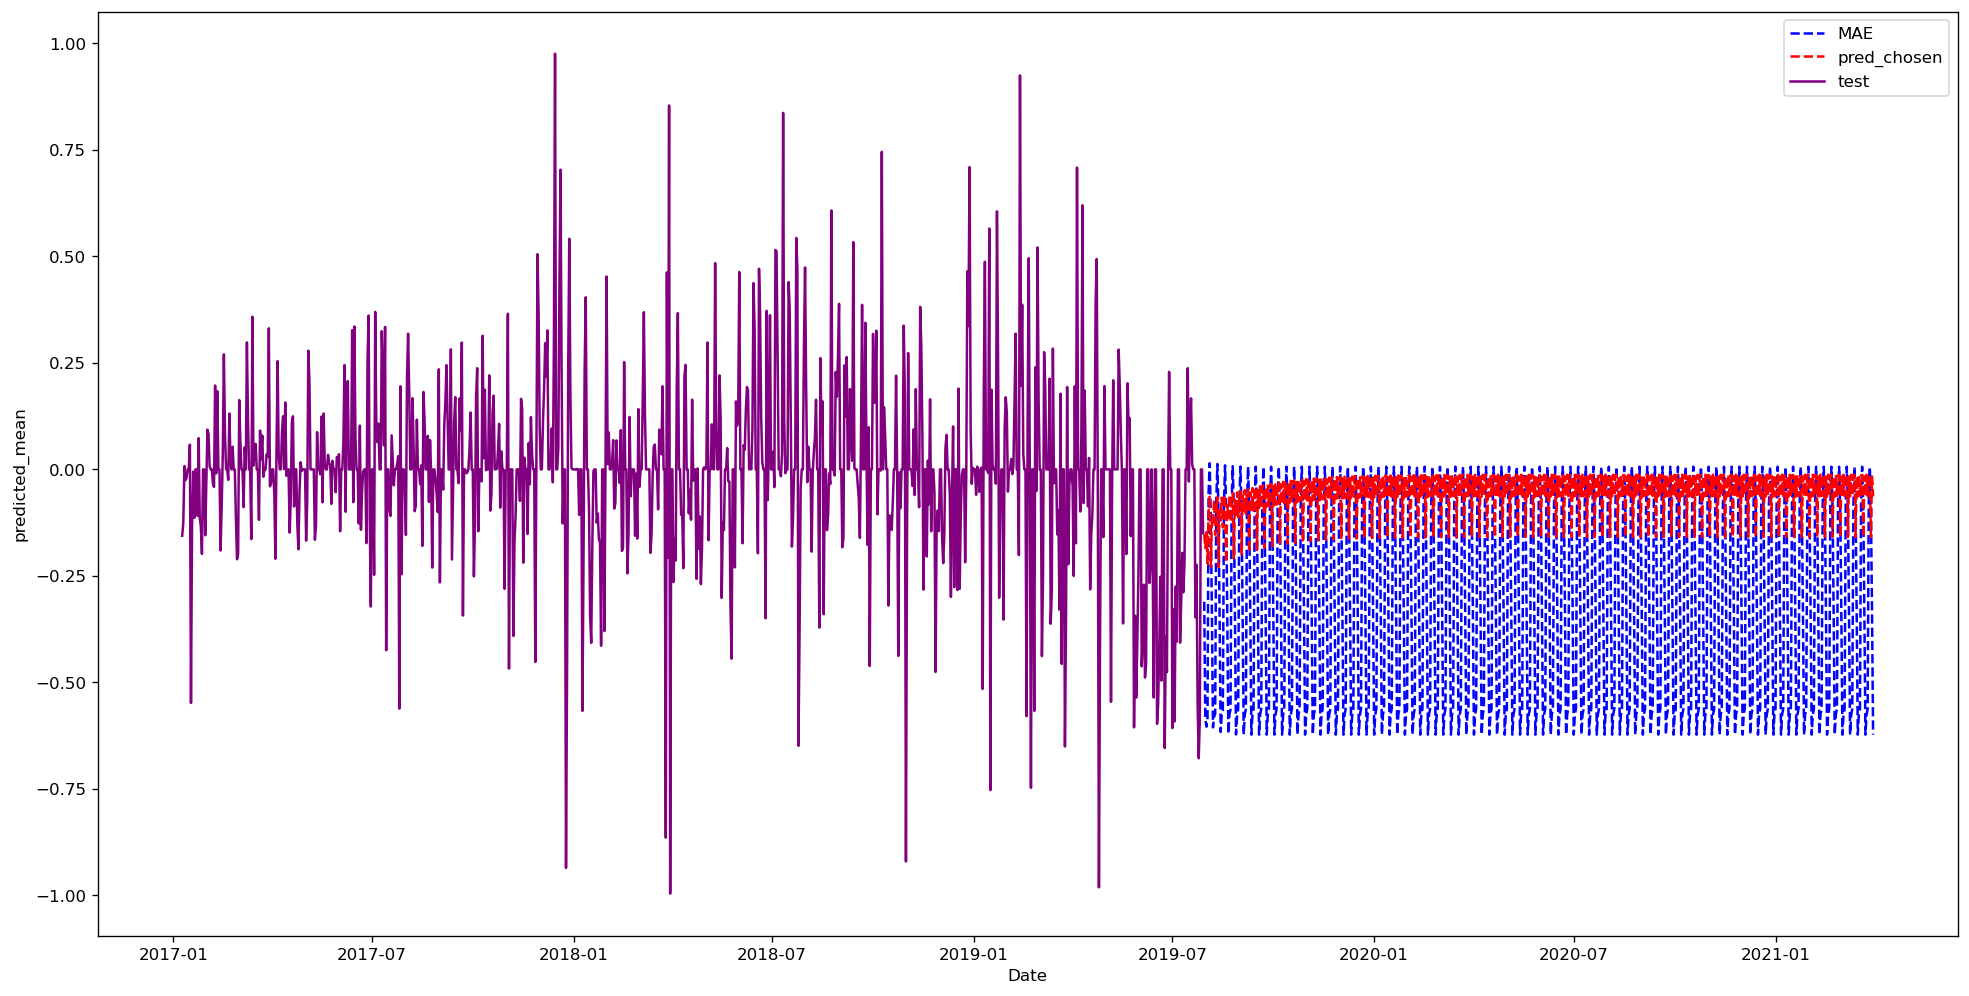

In [43]:
fig, ax = plt.subplots(figsize=(20, 10))
sns.lineplot(x=new_df.index[mask_after], y=predict_MAE, label='MAE', linestyle='dashed', color='blue', ax = ax)
sns.lineplot(x=new_df.index[mask_after], y=predict_chosen, label='pred_chosen', linestyle='dashed', color='red', ax=ax)

sns.lineplot(x=new_df.index[mask_before], y=new_df.Balance[mask_before], label='test', color = 'purple')

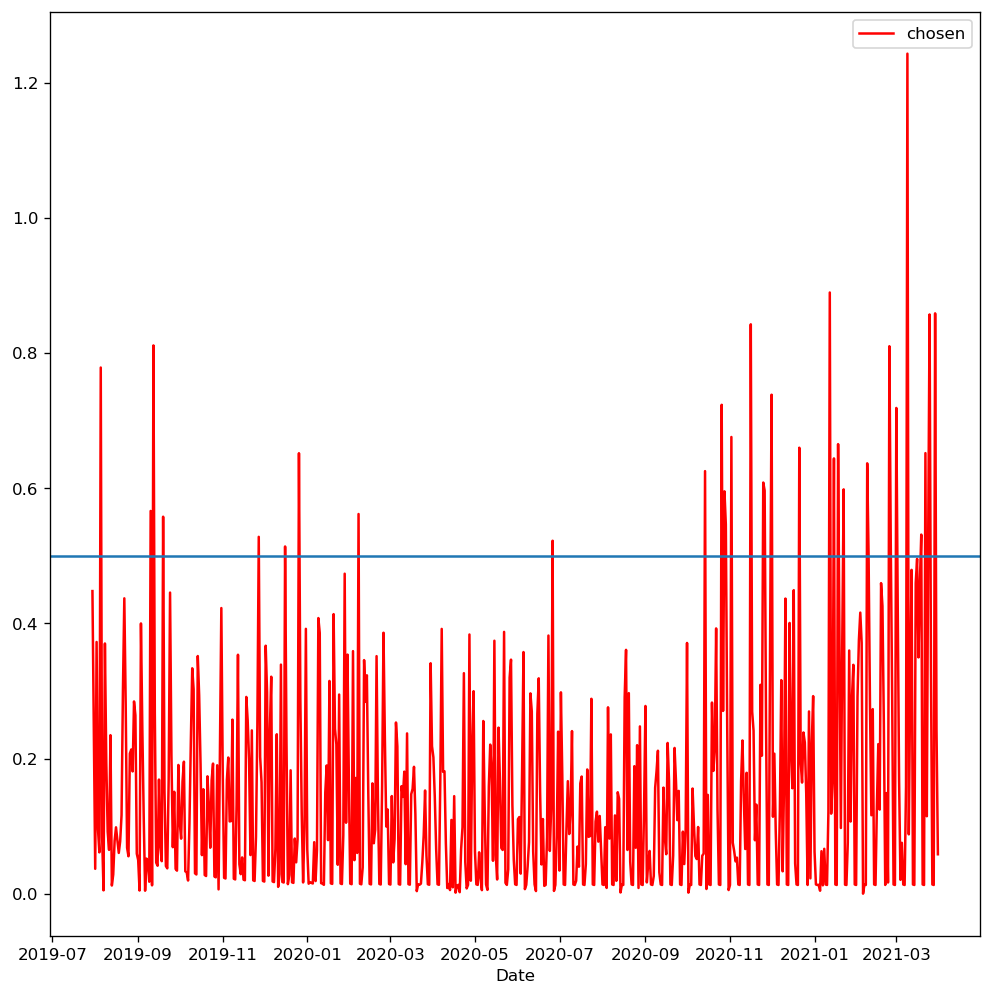

In [44]:
# sns.lineplot(x=df.index[mask_after], y=(df.Balance[mask_after]-predict_MAE).abs(), label='MAE', color = 'blue')
sns.lineplot(x=new_df.index[mask_after], y=(new_df.Balance[mask_after]-predict_chosen).abs(), label='chosen', color = 'red')
# sns.lineplot(x=df.index[mask], y=(df.Balance[mask]-predict_auto).abs(), label='auto', color = 'green')
plt.axhline(y=0.5) 

In [45]:
print(f"mean chosen = {(new_df.Balance[mask_after]-predict_chosen).abs().mean()}")
print(f"mean by_MAE = {(new_df.Balance[mask_after]-predict_MAE).abs().mean()}")
print(f"max chosen = {(new_df.Balance[mask_after]-predict_chosen).abs().max()}")
print(f"max by_MAE = {(new_df.Balance[mask_after]-predict_MAE).abs().max()}")

mean chosen = 0.15551274687633912
mean by_MAE = 0.310132199306699
max chosen = 1.2430956413970613
max by_MAE = 1.343551948975747


### Предположим мы взяли chosen модель

**Посмотрим как ведут себя остатки**

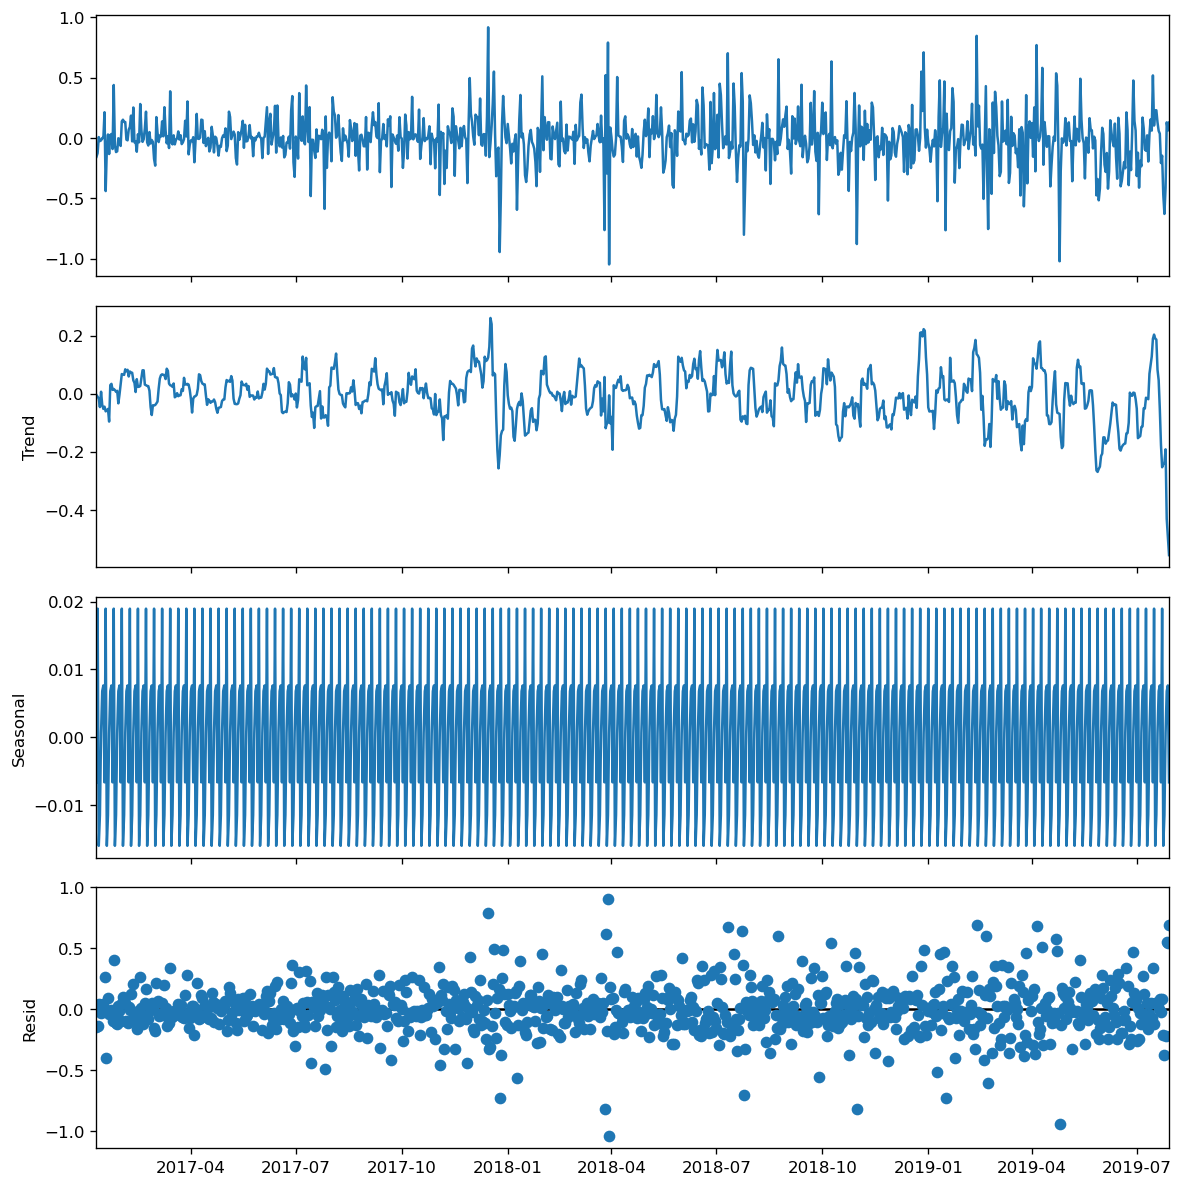

In [46]:
result_add = seasonal_decompose(best_SARIMAX.resid, model='additive', extrapolate_trend='freq')

plt.rcParams.update({'figure.figsize': (10,10)})
result_add.plot()
plt.show()

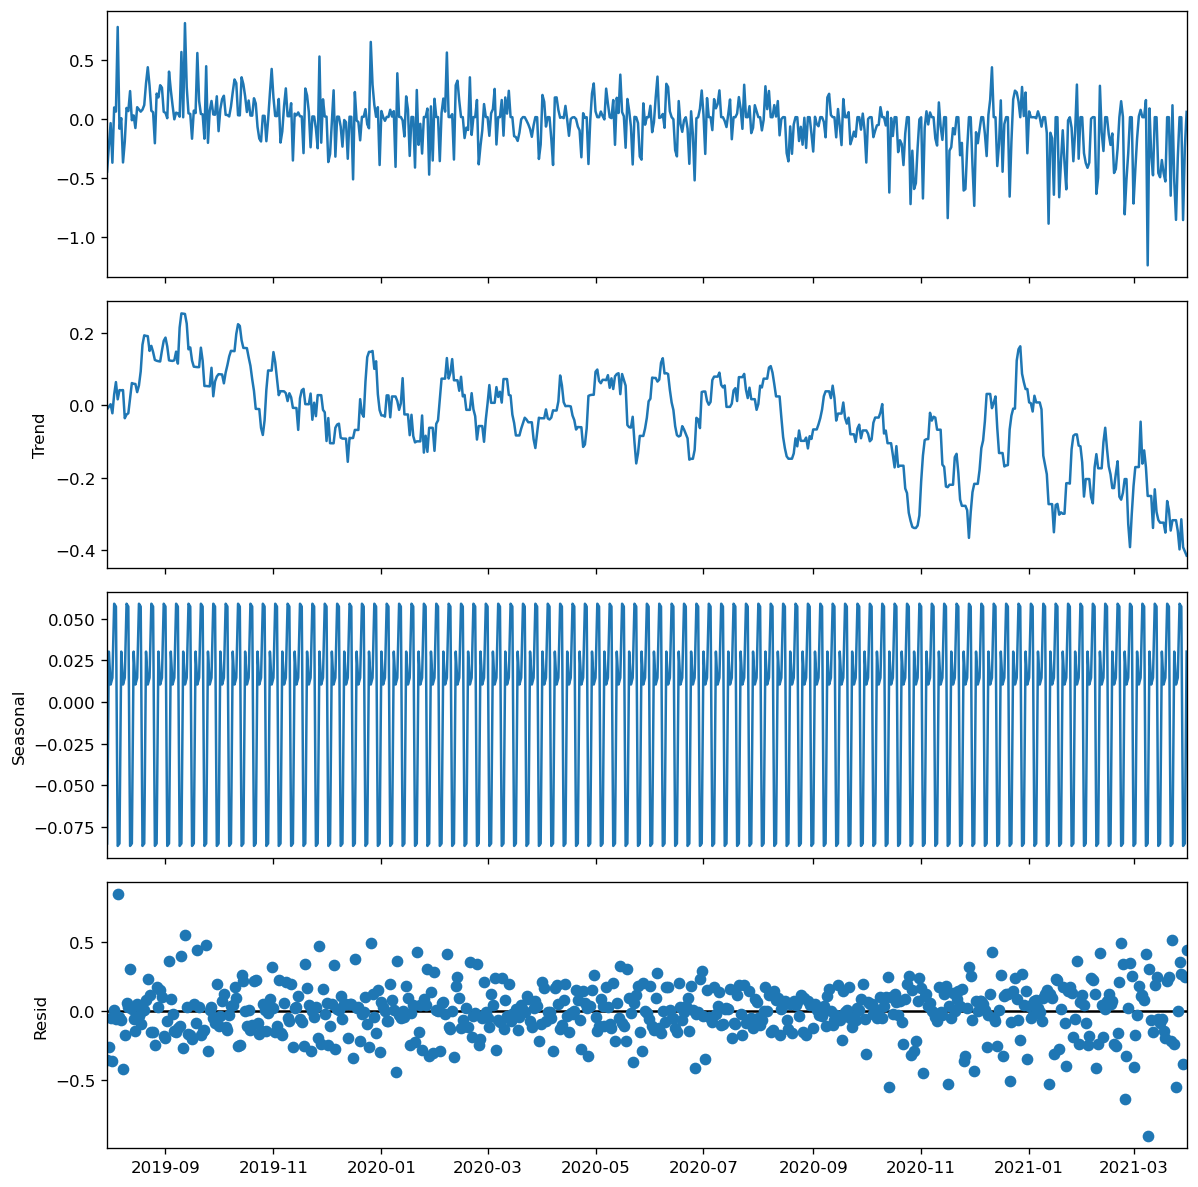

In [47]:
result_add = seasonal_decompose(new_df.Balance[mask_after] - predict_chosen, model='additive', extrapolate_trend='freq')

plt.rcParams.update({'figure.figsize': (10,10)})
result_add.plot()
plt.show()

# Попробуем зафигачить фичи дополнительные

# Курс доллара

In [48]:
print(new_df.index[0], new_df.index[-1])

2017-01-09 00:00:00 2021-03-31 00:00:00


In [49]:
USD_RUB_df = pd.read_csv(
    "/home/owner/Documents/DEV/Time_series/USD_RUB.csv",
    index_col='Дата', 
    parse_dates=['Дата'],
    usecols=['Дата', 'Цена'],
    )

In [50]:
USD_RUB_df.rename(columns={'Цена' : 'USD'}, inplace=True)

In [51]:
new_df = new_df.join(USD_RUB_df)
new_df

Balance      USD
Date                         
2017-01-09 -0.155904  57,5159
2017-01-10 -0.125572      NaN
2017-01-11  0.007767  58,2807
2017-01-12 -0.025294  58,8960
2017-01-13 -0.019721  59,6869
...              ...      ...
2021-03-27  0.000000      NaN
2021-03-28  0.000000      NaN
2021-03-29 -1.017679  75,6648
2021-03-30 -0.259687  75,8495
2021-03-31 -0.004878  75,6987

[1543 rows x 2 columns]

In [52]:
while not new_df.USD.notna().all():
    new_df.fillna(new_df.shift(1), inplace=True)

In [53]:
new_df.USD = new_df.USD.str.replace(',', '.').astype(float)

# ВВП РФ

In [54]:
GDP = {2016: 1.28, 2017: 1.57, 2018: 1.66, 2019: 1.69, 2020: 1.49, 2021: 1.84} # in trillions

new_df['last_year_GDP'] = (new_df.index.year - 1)
new_df['last_year_GDP'] = new_df['last_year_GDP'].apply(lambda x: GDP[x])

# Ключевая ставка

In [55]:
keyRates = pd.read_csv('/home/owner/Documents/DEV/Time_series/KeyRate.csv')

# Праздничные дни

In [56]:
import holidays

In [57]:
all_holidays = pd.to_datetime(np.fromiter(holidays.RU(years=[2017, 2018, 2019, 2020, 2021]).keys(), 'datetime64[ns]'))
all_holidays

DatetimeIndex(['2017-01-01', '2017-01-02', '2017-01-03', '2017-01-04',
               '2017-01-05', '2017-01-06', '2017-01-08', '2017-01-07',
               '2017-02-23', '2017-03-08', '2017-05-01', '2017-05-09',
               '2017-06-12', '2017-11-04', '2018-01-01', '2018-01-02',
               '2018-01-03', '2018-01-04', '2018-01-05', '2018-01-06',
               '2018-01-08', '2018-01-07', '2018-02-23', '2018-03-08',
               '2018-05-01', '2018-05-09', '2018-06-12', '2018-11-04',
               '2019-01-01', '2019-01-02', '2019-01-03', '2019-01-04',
               '2019-01-05', '2019-01-06', '2019-01-08', '2019-01-07',
               '2019-02-23', '2019-03-08', '2019-05-01', '2019-05-09',
               '2019-06-12', '2019-11-04', '2020-01-01', '2020-01-02',
               '2020-01-03', '2020-01-04', '2020-01-05', '2020-01-06',
               '2020-01-08', '2020-01-07', '2020-02-23', '2020-03-08',
               '2020-05-01', '2020-05-09', '2020-06-12', '2020-11-04',
      

In [58]:
new_df['holiday'] = new_df.index.isin(all_holidays).astype(int)

In [59]:
new_df.holiday.any()

True

In [60]:
bool_holiday = new_df.holiday.astype(bool)
new_df['week_before_holiday'] = bool_holiday.shift(-1).fillna(0)| \
    bool_holiday.shift(-2).fillna(0) | bool_holiday.shift(-3).fillna(0) | \
    bool_holiday.shift(-4).fillna(0) | bool_holiday.shift(-5).fillna(0) | \
    bool_holiday.shift(-6).fillna(0) | bool_holiday.shift(-7).fillna(0)
new_df.week_before_holiday = new_df.week_before_holiday.astype(int)

In [61]:
new_df['day_before_holiday'] = new_df.holiday.shift(-1).fillna(0).astype(int)

In [62]:
new_df

Balance      USD  last_year_GDP  holiday  week_before_holiday  \
Date                                                                         
2017-01-09 -0.155904  57.5159           1.28        0                    0   
2017-01-10 -0.125572  57.5159           1.28        0                    0   
2017-01-11  0.007767  58.2807           1.28        0                    0   
2017-01-12 -0.025294  58.8960           1.28        0                    0   
2017-01-13 -0.019721  59.6869           1.28        0                    0   
...              ...      ...            ...      ...                  ...   
2021-03-27  0.000000  75.6633           1.49        0                    0   
2021-03-28  0.000000  75.6633           1.49        0                    0   
2021-03-29 -1.017679  75.6648           1.49        0                    0   
2021-03-30 -0.259687  75.8495           1.49        0                    0   
2021-03-31 -0.004878  75.6987           1.49        0                    0   

            day_before_holiday  
Date                            
2017-01-09                   0  
2017-01-10                   0  
2017-01-11                   0  
2017-01-12                   0  
2017-01-13                   0  
...                        ...  
2021-03-27                   0  
2021-03-28                   0  
2021-03-29                   0  
2021-03-30                   0  
2021-03-31                   0  

[1543 rows x 6 columns]

# Мб еще отдельно обработаем даты

Типо выделим месяцы и заэнкодим мб времена года

In [63]:
test = new_df.index.month
test

Int64Index([1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
            ...
            3, 3, 3, 3, 3, 3, 3, 3, 3, 3],
           dtype='int64', name='Date', length=1543)

In [64]:
new_df['spring'] = new_df.index.month.isin([3,4,5]).astype(int)
new_df['summer'] = new_df.index.month.isin([6,7,8]).astype(int)
new_df['autumn'] = new_df.index.month.isin([9,10,11]).astype(int)
new_df['winter'] = new_df.index.month.isin([12,1,2]).astype(int)

Сделаем энкодинг дней недели

In [65]:
new_df['weekdays'] = new_df.index.day_name()
new_df = new_df.join(new_df['weekdays'].str.get_dummies()).drop(columns='weekdays')
for weekday in new_df.index.day_name().unique(): new_df[weekday] = new_df[weekday].astype(int)

In [66]:
new_df['month'] = new_df.index.month_name()
new_df = new_df.join(new_df['month'].str.get_dummies()).drop(columns='month')

In [67]:
new_df.columns

Index(['Balance', 'USD', 'last_year_GDP', 'holiday', 'week_before_holiday',
       'day_before_holiday', 'spring', 'summer', 'autumn', 'winter', 'Friday',
       'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday',
       'April', 'August', 'December', 'February', 'January', 'July', 'June',
       'March', 'May', 'November', 'October', 'September'],
      dtype='object')

Средние значения таргета в каждом месяце

In [68]:
months = new_df.index.month_name().unique()
new_df['avg_Balance_by_this_month'] = 0
for month in months:
    mask = new_df[month].astype(bool)
    new_df[mask]['avg_Balance_by_this_month'] = new_df[mask]['Balance'].mean()

Средние значения таргета по выходным

In [69]:
mask = (new_df.Saturday | new_df.Sunday).astype(bool)
new_df[mask]['avg_Balance_weekend'] = new_df[mask]['Balance'].mean()

Средние значения по временам года

In [70]:
seasons = ['winter', 'spring', 'summer', 'autumn']
new_df['avg_Balance_by_season'] = 0
for season in seasons:
    mask = new_df[season].astype(bool)
    new_df[mask]['avg_Balance_by_season'] = new_df[mask]['Balance'].mean()

Средние значения по неделе месяца

In [71]:
new_df[mask]['avg_Balance_by_week_of_month'] = 0

mask = new_df.index.day <= 7
new_df[mask]['avg_Balance_by_week_of_month'] = new_df[mask]['Balance'].mean()
mask = (new_df.index.day >= 8) & (new_df.index.day <= 14) 
new_df[mask]['avg_Balance_by_week_of_month'] = new_df[mask]['Balance'].mean()
mask = (new_df.index.day >= 15) & (new_df.index.day <= 21) 
new_df[mask]['avg_Balance_by_week_of_month'] = new_df[mask]['Balance'].mean()
mask = new_df.index.day >= 22
new_df[mask]['avg_Balance_by_week_of_month'] = new_df[mask]['Balance'].mean()

Пусть будет признак четности года

In [72]:
new_df['even_year'] = (~(new_df.index.year % 2).astype(bool)).astype(int)

Средние по дням недели

In [73]:
new_df['avg_Balance_by_day'] = 0
for week_day in new_df.index.day_name():
    mask = new_df[week_day].astype(bool)
    new_df[mask]['avg_Balance_by_season'] = new_df[mask]['Balance'].mean()

Средняя по кварталам

In [74]:
new_df[mask]['avg_Balance_by_quartal'] = 0

mask = new_df.index.month.isin([1,2,3])
new_df[mask]['avg_Balance_by_quartal'] = new_df[mask]['Balance'].mean()
mask = new_df.index.month.isin([4,5,6])
new_df[mask]['avg_Balance_by_quartal'] = new_df[mask]['Balance'].mean()
mask = new_df.index.month.isin([7,8,9])
new_df[mask]['avg_Balance_by_quartal'] = new_df[mask]['Balance'].mean()
mask = new_df.index.month.isin([10,11,12])
new_df[mask]['avg_Balance_by_quartal'] = new_df[mask]['Balance'].mean()

# Налоговые дни

Для ЕНС установлены единые сроки: до 25 числа месяца, следующего за отчетным периодом, нужно отчитаться перед налоговой, а до 28 числа — уплатить налоги.

In [75]:
new_df['tax_day'] = new_df.index.day.isin([28]).astype(int)

# Сдвиги

In [76]:
n_shifts = 8
for i in range(1, n_shifts+1):
    new_df[f'shift_{i}'] = new_df.Balance.shift(i)
new_df = new_df[n_shifts:]

# new_df

In [77]:
new_df

Balance      USD  last_year_GDP  holiday  week_before_holiday  \
Date                                                                         
2017-01-17 -0.548519  59.4025           1.28        0                    0   
2017-01-18 -0.124801  59.5544           1.28        0                    0   
2017-01-19 -0.005391  59.7304           1.28        0                    0   
2017-01-20 -0.113900  59.7521           1.28        0                    0   
2017-01-21  0.000000  59.7521           1.28        0                    0   
...              ...      ...            ...      ...                  ...   
2021-03-27  0.000000  75.6633           1.49        0                    0   
2021-03-28  0.000000  75.6633           1.49        0                    0   
2021-03-29 -1.017679  75.6648           1.49        0                    0   
2021-03-30 -0.259687  75.8495           1.49        0                    0   
2021-03-31 -0.004878  75.6987           1.49        0                    0   

            day_before_holiday  spring  summer  autumn  winter  ...  \
Date                                                            ...   
2017-01-17                   0       0       0       0       1  ...   
2017-01-18                   0       0       0       0       1  ...   
2017-01-19                   0       0       0       0       1  ...   
2017-01-20                   0       0       0       0       1  ...   
2017-01-21                   0       0       0       0       1  ...   
...                        ...     ...     ...     ...     ...  ...   
2021-03-27                   0       1       0       0       0  ...   
2021-03-28                   0       1       0       0       0  ...   
2021-03-29                   0       1       0       0       0  ...   
2021-03-30                   0       1       0       0       0  ...   
2021-03-31                   0       1       0       0       0  ...   

            avg_Balance_by_day  tax_day   shift_1   shift_2   shift_3  \
Date                                                                    
2017-01-17                   0        0  0.057996  0.000000  0.000000   
2017-01-18                   0        0 -0.548519  0.057996  0.000000   
2017-01-19                   0        0 -0.124801 -0.548519  0.057996   
2017-01-20                   0        0 -0.005391 -0.124801 -0.548519   
2017-01-21                   0        0 -0.113900 -0.005391 -0.124801   
...                        ...      ...       ...       ...       ...   
2021-03-27                   0        0 -0.393913 -0.869810 -0.587778   
2021-03-28                   0        1  0.000000 -0.393913 -0.869810   
2021-03-29                   0        0  0.000000  0.000000 -0.393913   
2021-03-30                   0        0 -1.017679  0.000000  0.000000   
2021-03-31                   0        0 -0.259687 -1.017679  0.000000   

             shift_4   shift_5   shift_6   shift_7   shift_8  
Date                                                          
2017-01-17 -0.019721 -0.025294  0.007767 -0.125572 -0.155904  
2017-01-18  0.000000 -0.019721 -0.025294  0.007767 -0.125572  
2017-01-19  0.000000  0.000000 -0.019721 -0.025294  0.007767  
2017-01-20  0.057996  0.000000  0.000000 -0.019721 -0.025294  
2017-01-21 -0.548519  0.057996  0.000000  0.000000 -0.019721  
...              ...       ...       ...       ...       ...  
2021-03-27  0.098041 -0.810884  0.000000  0.000000 -0.594002  
2021-03-28 -0.587778  0.098041 -0.810884  0.000000  0.000000  
2021-03-29 -0.869810 -0.587778  0.098041 -0.810884  0.000000  
2021-03-30 -0.393913 -0.869810 -0.587778  0.098041 -0.810884  
2021-03-31  0.000000 -0.393913 -0.869810 -0.587778  0.098041  

[1535 rows x 42 columns]

# Пытаемся замутить SARIMAX

In [78]:
best_SARIMAX.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                              Balance   No. Observations:                  932
Model:             ARIMA(3, 0, 3)x(0, 1, [1, 2], 7)   Log Likelihood                 123.764
Date:                              Fri, 05 Apr 2024   AIC                           -229.527
Time:                                      20:52:47   BIC                           -186.059
Sample:                                  01-09-2017   HQIC                          -212.944
                                       - 07-29-2019                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5552      0.051     10.839      0.000       0.455       0.656
ar.L2         -0.4772      0.058     -8.235      0.000      -0.591      -0.364
ar.L3          0.8684      0.042     20.538      0.000       0.786       0.951
ma.L1         -0.4433      0.051     -8.706      0.000      -0.543      -0.344
ma.L2          0.4442      0.048      9.197      0.000       0.350       0.539
ma.L3         -0.8497      0.043    -19.539      0.000      -0.935      -0.764
ma.S.L7       -0.8670      0.034    -25.704      0.000      -0.933      -0.801
ma.S.L14      -0.1092      0.033     -3.311      0.001      -0.174      -0.045
sigma2         0.0438      0.001     35.142      0.000       0.041       0.046
===================================================================================
Ljung-Box (L1) (Q):                   2.07   Jarque-Bera (JB):               575.87
Prob(Q):                              0.15   Prob(JB):                         0.00
Heteroskedasticity (H):               3.22   Skew:                            -0.23
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.84
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [79]:
new_df.columns

Index(['Balance', 'USD', 'last_year_GDP', 'holiday', 'week_before_holiday',
       'day_before_holiday', 'spring', 'summer', 'autumn', 'winter', 'Friday',
       'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday',
       'April', 'August', 'December', 'February', 'January', 'July', 'June',
       'March', 'May', 'November', 'October', 'September',
       'avg_Balance_by_this_month', 'avg_Balance_by_season', 'even_year',
       'avg_Balance_by_day', 'tax_day', 'shift_1', 'shift_2', 'shift_3',
       'shift_4', 'shift_5', 'shift_6', 'shift_7', 'shift_8'],
      dtype='object')

In [80]:
# new_df_train = new_df[new_df.index < threshold_date]
# new_df_test = new_df[mask_after]
exog = list(filter(lambda column: column != 'Balance' and not column.startswith("shift"), new_df.columns))

In [85]:
new_df

Balance      USD  last_year_GDP  holiday  week_before_holiday  \
Date                                                                         
2017-01-17 -0.548519  59.4025           1.28        0                    0   
2017-01-18 -0.124801  59.5544           1.28        0                    0   
2017-01-19 -0.005391  59.7304           1.28        0                    0   
2017-01-20 -0.113900  59.7521           1.28        0                    0   
2017-01-21  0.000000  59.7521           1.28        0                    0   
...              ...      ...            ...      ...                  ...   
2021-03-27  0.000000  75.6633           1.49        0                    0   
2021-03-28  0.000000  75.6633           1.49        0                    0   
2021-03-29 -1.017679  75.6648           1.49        0                    0   
2021-03-30 -0.259687  75.8495           1.49        0                    0   
2021-03-31 -0.004878  75.6987           1.49        0                    0   

            day_before_holiday  spring  summer  autumn  winter  ...  \
Date                                                            ...   
2017-01-17                   0       0       0       0       1  ...   
2017-01-18                   0       0       0       0       1  ...   
2017-01-19                   0       0       0       0       1  ...   
2017-01-20                   0       0       0       0       1  ...   
2017-01-21                   0       0       0       0       1  ...   
...                        ...     ...     ...     ...     ...  ...   
2021-03-27                   0       1       0       0       0  ...   
2021-03-28                   0       1       0       0       0  ...   
2021-03-29                   0       1       0       0       0  ...   
2021-03-30                   0       1       0       0       0  ...   
2021-03-31                   0       1       0       0       0  ...   

            avg_Balance_by_day  tax_day   shift_1   shift_2   shift_3  \
Date                                                                    
2017-01-17                   0        0  0.057996  0.000000  0.000000   
2017-01-18                   0        0 -0.548519  0.057996  0.000000   
2017-01-19                   0        0 -0.124801 -0.548519  0.057996   
2017-01-20                   0        0 -0.005391 -0.124801 -0.548519   
2017-01-21                   0        0 -0.113900 -0.005391 -0.124801   
...                        ...      ...       ...       ...       ...   
2021-03-27                   0        0 -0.393913 -0.869810 -0.587778   
2021-03-28                   0        1  0.000000 -0.393913 -0.869810   
2021-03-29                   0        0  0.000000  0.000000 -0.393913   
2021-03-30                   0        0 -1.017679  0.000000  0.000000   
2021-03-31                   0        0 -0.259687 -1.017679  0.000000   

             shift_4   shift_5   shift_6   shift_7   shift_8  
Date                                                          
2017-01-17 -0.019721 -0.025294  0.007767 -0.125572 -0.155904  
2017-01-18  0.000000 -0.019721 -0.025294  0.007767 -0.125572  
2017-01-19  0.000000  0.000000 -0.019721 -0.025294  0.007767  
2017-01-20  0.057996  0.000000  0.000000 -0.019721 -0.025294  
2017-01-21 -0.548519  0.057996  0.000000  0.000000 -0.019721  
...              ...       ...       ...       ...       ...  
2021-03-27  0.098041 -0.810884  0.000000  0.000000 -0.594002  
2021-03-28 -0.587778  0.098041 -0.810884  0.000000  0.000000  
2021-03-29 -0.869810 -0.587778  0.098041 -0.810884  0.000000  
2021-03-30 -0.393913 -0.869810 -0.587778  0.098041 -0.810884  
2021-03-31  0.000000 -0.393913 -0.869810 -0.587778  0.098041  

[1535 rows x 42 columns]

In [93]:
import itertools
import math
from sklearn.metrics import r2_score, mean_absolute_error

# Define the range of values for p, d, q, P, D, Q, and m
p_values = range(0, 4)  # Autoregressive order
d_values = [0]          # Differencing order
q_values = range(0, 4)  # Moving average order
P_values = range(0, 5) # Seasonal autoregressive order
D_values = [1]  # Seasonal differencing order
Q_values = range(0, 3)  # Seasonal moving average order
m_values = [7]         # Seasonal period

# Create all possible combinations of SARIMA parameters
param_combinations = list(itertools.product(p_values, 
                                            d_values, 
                                            q_values, 
                                            P_values, 
                                            D_values, 
                                            Q_values, 
                                            m_values))
results_exog = []

# Initialize AIC with a large value
best_aic_SARIMAX = float("inf")  
best_params_SARIMAX = None
best_SARIMAX = None
mask_before = (new_df.index < threshold_date) & (new_df.index >= start_date)
mask_after = (new_df.index >= threshold_date) & (new_df.index <= end_date)

warnings.filterwarnings('ignore')


# Perform grid search
for params in tqdm(param_combinations):
    order = params[:3]
    seasonal_order = params[3:]
    
    try:
        model_chosen = ARIMA(endog=new_df[mask_before].Balance,
                               exog=new_df[mask_before][exog],
                               order=order, 
                               seasonal_order=seasonal_order)
        model_chosen = model_chosen.fit()
        aic = model_chosen.aic
        
        # Ensure the convergence of the model
        if not math.isinf(model_chosen.zvalues.mean()):
            predict=model_chosen.predict(start=threshold_date, end=end_date, exog=new_df[mask_after][exog])
            err_max = (new_df.Balance[mask_after]-predict).abs().max()
            mae = mean_absolute_error(new_df.Balance[mask_after], predict)
            llf = model_chosen.llf
            r2 = r2_score(new_df.Balance[mask_after], predict)
            aic = model_chosen.aic
            if aic < best_aic_SARIMAX:
                best_aic_SARIMAX = aic
                best_params_SARIMAX = params
                best_SARIMAX = model_chosen
                best_err_max = err_max
                best_mae = mae
                best_llf = llf
                best_r2 = r2
                best_combination = params
                best_aic_SARIMAX = aic
            results_exog.append(list(params[:-1]) + [err_max, mae, llf, r2, aic])
        else:
            print(order, seasonal_order, 'not converged')
    except ValueError as err:
        print('wrong parameters:', params)
        print(err.args)
        continue

# Print the best parameters and AIC
print("Best Parameters:", best_params_SARIMAX)
print("Best AIC:", best_aic_SARIMAX)

100%|██████████| 240/240 [1:13:24<00:00, 18.35s/it]

Best Parameters: (0, 0, 1, 4, 1, 1, 7)
Best AIC: -160.8359263210031


In [94]:
result_exog_table = pd.DataFrame(results_exog)
result_exog_table.columns = ['p', 'd', 'q', 'P', 'D', 'Q', 'err_max', 'MAE', 'LLF', 'R2', 'aic']
print("by LLF:")
display(result_exog_table.sort_values(by=['LLF'], ascending=False).head(1))
print("by err_max:")
display(result_exog_table.sort_values(by=['err_max'], ascending=True).head(1))
print("by MAE:")
display(result_exog_table.sort_values(by=['MAE'], ascending=True).head(1))
print("by aic:")
display(result_exog_table.sort_values(by=['aic'], ascending=True).head(1))
print("by R2:")
display(result_exog_table.sort_values(by=['R2'], ascending=False).head(1))

by LLF:


p  d  q  P  D  Q  err_max       MAE         LLF        R2         aic
28  0  0  1  4  1  1  1.33008  0.178261  120.417963 -0.142224 -160.835926

by err_max:


p  d  q  P  D  Q   err_max      MAE        LLF        R2         aic
232  3  0  3  2  1  1  0.875194  0.22631  99.289935 -0.383389 -112.579871

by MAE:


p  d  q  P  D  Q   err_max       MAE         LLF        R2         aic
89  1  0  1  4  1  2  1.195299  0.165379  103.606407  0.054838 -123.212813

by aic:


p  d  q  P  D  Q  err_max       MAE         LLF        R2         aic
28  0  0  1  4  1  1  1.33008  0.178261  120.417963 -0.142224 -160.835926

by R2:


p  d  q  P  D  Q   err_max       MAE         LLF        R2         aic
89  1  0  1  4  1  2  1.195299  0.165379  103.606407  0.054838 -123.212813

In [119]:
predict_SARIMAX = best_SARIMAX.predict(start=threshold_date, end=end_date, exog=new_df[mask_after][exog])
print(len(predict_SARIMAX), len(new_df.index[mask_after]))

611 611


In [96]:
best_SARIMAX.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                    SARIMAX Results                                    
=======================================================================================
Dep. Variable:                         Balance   No. Observations:                  924
Model:             ARIMA(0, 0, 1)x(4, 1, 1, 7)   Log Likelihood                 120.418
Date:                         Fri, 05 Apr 2024   AIC                           -160.836
Time:                                 22:34:40   BIC                             32.008
Sample:                             01-17-2017   HQIC                           -87.234
                                  - 07-29-2019                                         
Covariance Type:                           opg                                         
=============================================================================================
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
USD                           0.0053      0.004      1.467      0.142      -0.002       0.012
last_year_GDP                -0.3383      0.143     -2.364      0.018      -0.619      -0.058
holiday                      -0.0042      0.083     -0.051      0.959      -0.167       0.158
week_before_holiday          -0.0103      0.024     -0.438      0.661      -0.057       0.036
day_before_holiday            0.0088      0.049      0.180      0.857      -0.087       0.105
spring                        0.0005      0.015      0.035      0.972      -0.028       0.029
summer                       -0.0132      0.014     -0.936      0.349      -0.041       0.014
autumn                       -0.0133      0.019     -0.710      0.477      -0.050       0.023
winter                        0.0063      0.014      0.457      0.647      -0.021       0.034
Friday                     4.665e-08   9.04e-09      5.158      0.000    2.89e-08    6.44e-08
Monday                     -8.24e-08   9.19e-09     -8.962      0.000      -1e-07   -6.44e-08
Saturday                  -3.492e-08   9.29e-09     -3.757      0.000   -5.31e-08   -1.67e-08
Sunday                    -3.362e-08   9.35e-09     -3.596      0.000   -5.19e-08   -1.53e-08
Thursday                   7.546e-10   9.19e-09      0.082      0.935   -1.72e-08    1.88e-08
Tuesday                    2.595e-07   9.21e-09     28.186      0.000    2.41e-07    2.78e-07
Wednesday                  5.452e-08   9.18e-09      5.940      0.000    3.65e-08    7.25e-08
April                         0.0010      0.024      0.040      0.968      -0.047       0.049
August                       -0.0022      0.036     -0.061      0.952      -0.072       0.068
December                      0.0119      0.030      0.397      0.692      -0.047       0.071
February                      0.0172      0.029      0.589      0.556      -0.040       0.075
January                      -0.0276      0.027     -1.029      0.304      -0.080       0.025
July                         -0.0048      0.023     -0.208      0.835      -0.050       0.041
June                         -0.0115      0.026     -0.444      0.657      -0.062       0.039
March                         0.0026      0.025      0.104      0.917      -0.046       0.051
May                          -0.0093      0.029     -0.321      0.748      -0.066       0.048
November                     -0.0315      0.031     -1.001      0.317      -0.093       0.030
October                       0.0029      0.029      0.099      0.921      -0.055       0.060
September                     0.0112      0.034      0.329      0.742      -0.055       0.078
avg_Balance_by_this_month          0   9.35e-09          0      1.000   -1.83e-08    1.83e-08
avg_Balance_by_season              0   9.35e-09          0      1.000   -1.83e-08    1.83e-08
even_year                     0.0581      0.026      2.194

In [118]:
display(result_exog_table.sort_values(by=['MAE'], ascending=True).head(1))

p  d  q  P  D  Q   err_max       MAE         LLF        R2         aic
89  1  0  1  4  1  2  1.195299  0.165379  103.606407  0.054838 -123.212813

In [131]:
SARIMAX_by_MAE = ARIMA(endog=new_df[mask_before].Balance,
                               exog=new_df[mask_before][exog],
                               order=(1,0,1), 
                               seasonal_order=(4,1,2,7)).fit()

In [132]:
predict_SARIMAX_MAE = SARIMAX_by_MAE.predict(start=threshold_date, end=end_date, exog=new_df[mask_after][exog])

In [128]:
display(result_exog_table.sort_values(by=['err_max'], ascending=True).head(1))

p  d  q  P  D  Q   err_max      MAE        LLF        R2         aic
232  3  0  3  2  1  1  0.875194  0.22631  99.289935 -0.383389 -112.579871

In [133]:
SARIMAX_by_err_max = ARIMA(endog=new_df[mask_before].Balance,
                               exog=new_df[mask_before][exog],
                               order=(3, 0, 3), 
                               seasonal_order=(2,1,1,7)).fit()

In [134]:
predict_SARIMAX_err_max = SARIMAX_by_MAE.predict(start=threshold_date, end=end_date, exog=new_df[mask_after][exog])

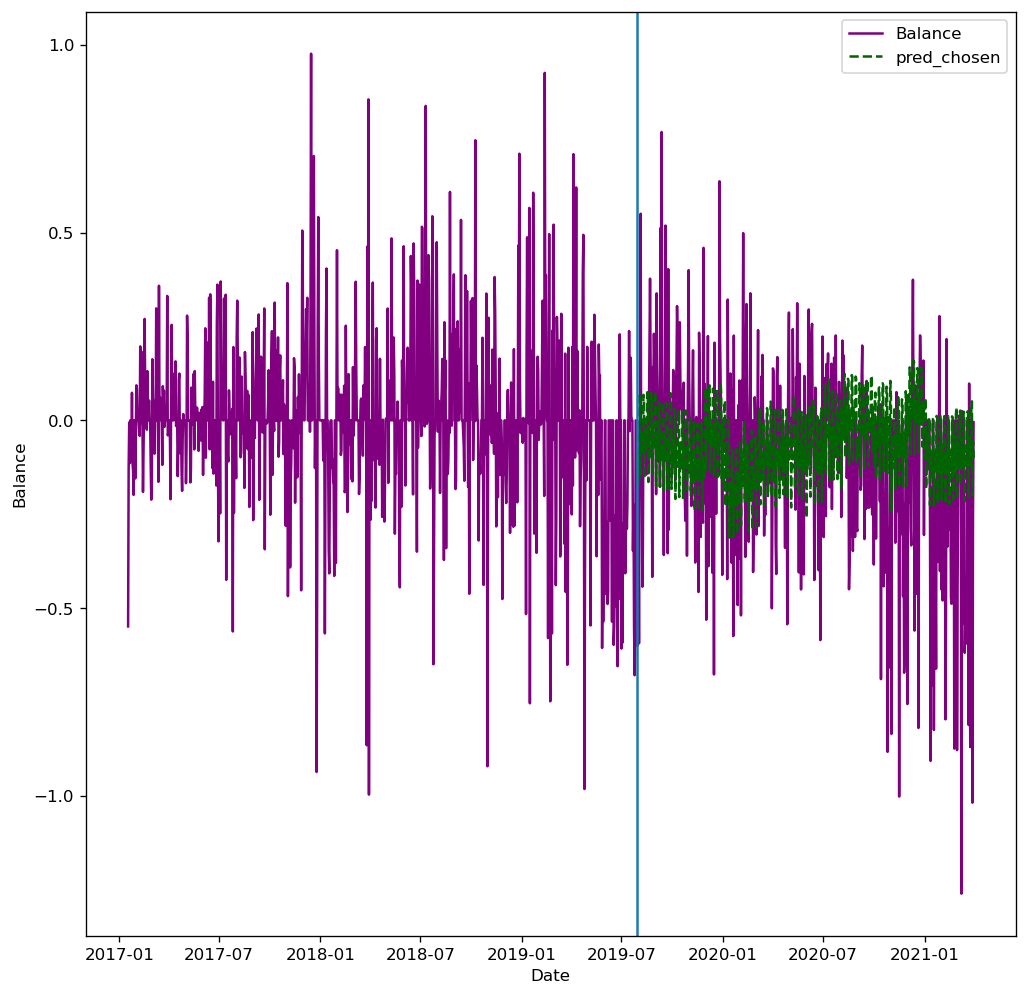

In [141]:
sns.lineplot(x=new_df.index, y=new_df.Balance, label='Balance', color = 'purple')
# sns.lineplot(x=new_df.index[mask_after], y=predict_SARIMAX, label='pred_chosen', linestyle='dashed', color='red')
sns.lineplot(x=new_df.index[mask_after], y=predict_SARIMAX_MAE, label='pred_chosen', linestyle='dashed', color='darkgreen')
# sns.lineplot(x=new_df.index[mask_after], y=predict_SARIMAX_err_max, label='pred_chosen', linestyle='dashed', color='black')
plt.axvline(x=threshold_date)

# Boosting

In [101]:
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

In [106]:
X = new_df.drop(columns='Balance')
y = new_df.Balance

X_train, X_test = X[mask_before], X[mask_after]
y_train, y_test = y[mask_before], y[mask_after]

In [458]:
modelSK = GradientBoostingRegressor(n_estimators=300, 
                                    min_samples_leaf=10, 
                                    loss='absolute_error')
modelSK.fit(X_train, y_train)
modelXGB = XGBRegressor(n_estimators=300,  objective='reg:quantileerror',quantile_alpha=0.09)
modelXGB.fit(X_train, y_train)
modelLGBM = XGBRegressor(
            n_estimators=300,
            objective='reg:quantileerror',
            quantile_alpha=0.09,
            )
modelLGBM.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=300, n_jobs=None,
             num_parallel_tree=None, objective='reg:quantileerror', ...)

In [459]:
predictSK = modelSK.predict(X_test)
predictXGB = modelXGB.predict(X_test)
predictLGBM = modelLGBM.predict(X_test)

<Axes: xlabel='Date', ylabel='Balance'>

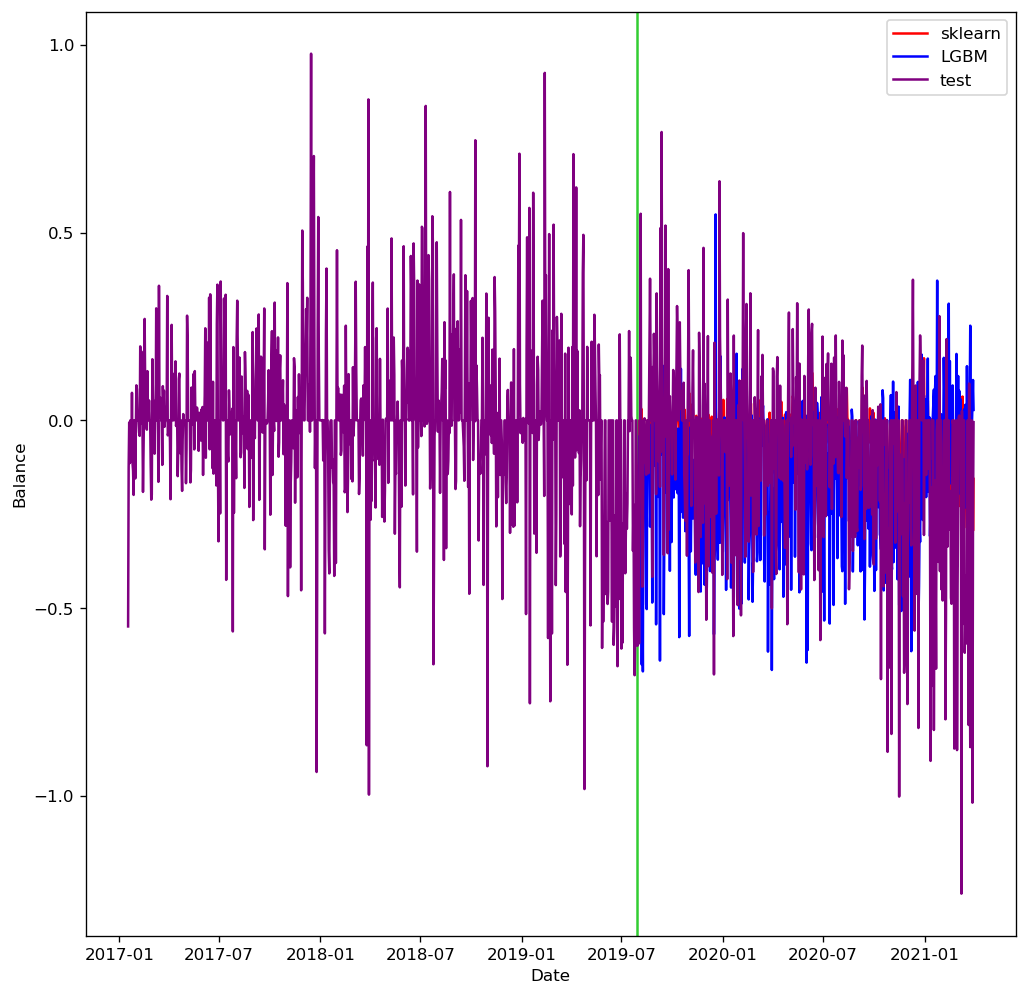

In [460]:
plt.axvline(x=threshold_date, color='limegreen')
sns.lineplot(x=new_df.index[mask_after], y=predictSK, label='sklearn', color='red')
# sns.lineplot(x=new_df.index[mask_after], y=predictXGB, label='XGB', color='darkgreen')
sns.lineplot(x=new_df.index[mask_after], y=predictLGBM, label='LGBM', color='blue')
sns.lineplot(x=new_df.index, y=new_df.Balance, label='test', color = 'purple')
